#Data Preprocessing

In [6]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
import pandas as pd
import numpy as np
import pickle
import copy
import operator
from tqdm import tqdm
from scipy.sparse import coo_matrix
from IPython.core.display import display, HTML
import implicit
display(HTML("<style>.container { width:90% !important; }</style>"))

/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


In [9]:
df = pd.read_csv('/content/ratings.dat', sep='::', names=["uid", "iid", "rating", "timestamp"])
df.drop(columns=['timestamp', 'rating'], inplace=True)
df.head(2)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,uid,iid
0,1,1193
1,1,661


In [10]:
df.dropna(inplace=True)

In [11]:
item_df = pd.read_csv('/content/movies.dat', sep='::', names=["iid", "title", "genres"], encoding='latin-1')
item_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,iid,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
print(f"Size of the User dataset: {df.shape}")
print(f"Size of the Item dataset: {item_df.shape}")
print(f"Features of User dataset: {df.columns}")
print(f"Features of Item dataset: {item_df.columns}")

Size of the User dataset: (1000209, 2)
Size of the Item dataset: (3883, 3)
Features of User dataset: Index(['uid', 'iid'], dtype='object')
Features of Item dataset: Index(['iid', 'title', 'genres'], dtype='object')


In [13]:
# count the number for each genre and sort
item_genre_dict = dict()
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_list = genre_str.split('|')
    item_genre_dict[item_df.at[i, 'iid']] = genre_list

genre_item_count = dict()
for l in item_genre_dict:
    for g in item_genre_dict[l]:
        if not g in genre_item_count:
            genre_item_count[g] = 1
        else:
            genre_item_count[g] += 1

genre_count_sorted = sorted(genre_item_count.items(), key=operator.itemgetter(1), reverse=True)
# genre_count_sorted

In [14]:
name=[genre_count_sorted[i][0] for i in range(len(genre_count_sorted))]
counts=[genre_count_sorted[i][1] for i in range(len(genre_count_sorted))]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of occurance')

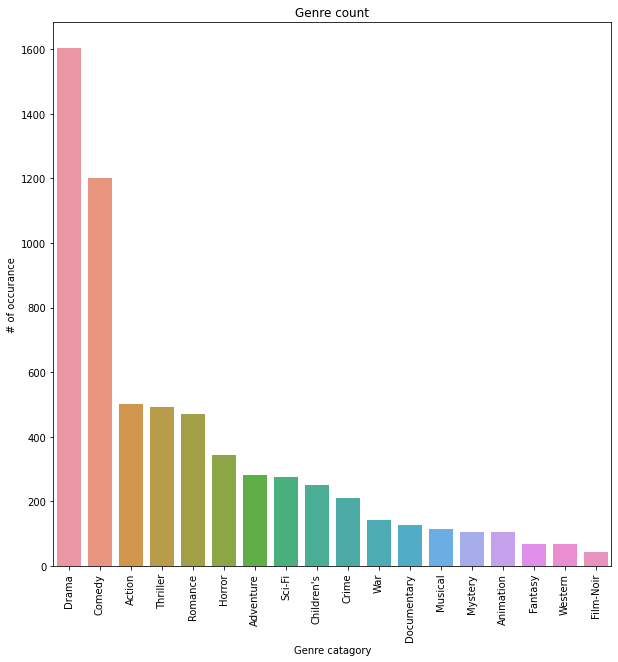

In [15]:
plt.figure(figsize=(10,10))
sns.barplot(name,counts)
plt.xticks(rotation=90)
plt.title("Genre count")
plt.xlabel("Genre catagory")
plt.ylabel("# of occurance")

In [16]:
# calculate feedback/item_count for each genre
genre_rating_count = dict()
itemIds = df['iid'].values
for i in range(len(itemIds)):
    itemId = itemIds[i]
    genres = item_genre_dict[itemId]
    for g in genres:
        if not g in genre_rating_count:
            genre_rating_count[g] = 1.
        else:
            genre_rating_count[g] += 1.
for g in genre_item_count:
  genre_rating_count[g] /= genre_item_count[g] * 1.
genre_count_sorted = sorted(genre_rating_count.items(), key=operator.itemgetter(1), reverse=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '# of occurance')

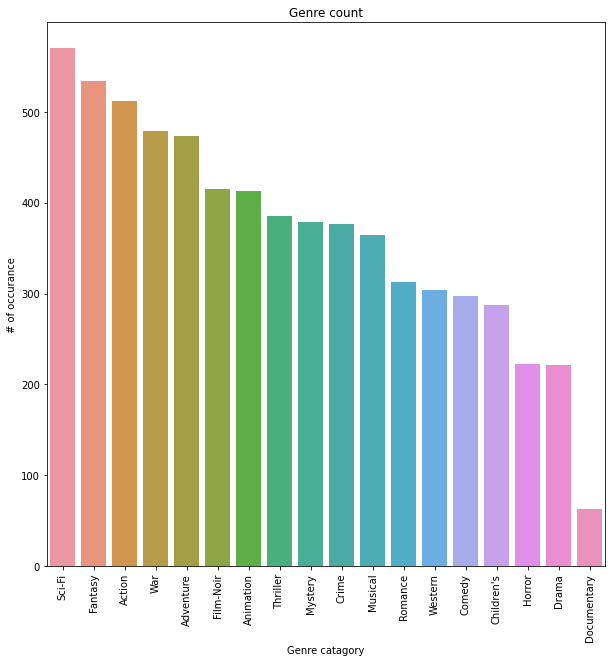

In [17]:
name=[genre_count_sorted[i][0] for i in range(len(genre_count_sorted))]
counts=[genre_count_sorted[i][1] for i in range(len(genre_count_sorted))]
plt.figure(figsize=(10,10))
sns.barplot(name,counts)
plt.xticks(rotation=90)
plt.title("Genre count")
plt.xlabel("Genre catagory")
plt.ylabel("# of occurance")

In [18]:
genres_used = set(list(genre_rating_count.keys())) - {'(no genres listed)'}

In [19]:
# filter items by genres
delete_list = []
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_list = genre_str.split('|')
    genre_overlap = genre_list
    if genre_str == '(no genres listed)':
        delete_list.append(i)
item_df.drop(delete_list, inplace=True)
keep_item_g = item_df['iid'].unique()
item_df.reset_index(drop=True, inplace=True)

In [20]:
# remove record for movies which do not have genres
df = df[df['iid'].isin(keep_item_g)]
df.reset_index(drop=True, inplace=True)

In [21]:
item_set = set(df['iid'].unique())
user_set = set(df['uid'].unique())
print('item num = ' + str(len(item_set)))
print('user num = ' + str(len(user_set)))

item num = 3706
user num = 6040


In [22]:
rdf = copy.copy(df)

In [23]:
rdf.shape

(1000209, 2)

In [24]:
keep_uid = np.random.choice(rdf['uid'].unique(), 1000, replace=False)

In [25]:
rdf = rdf[rdf['uid'].isin(keep_uid)]
rdf.reset_index(drop=True, inplace=True)

In [26]:
item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
print('movie num = ' + str(len(item_list)))
print('user num = ' + str(len(user_list)))
print('sparsity: ' + str(len(rdf) * 1.0 / (len(user_list) * len(item_list))))

movie num = 3392
user num = 1000
sparsity: 0.04625029481132076


In [27]:
#remove movies from item_df
item_df = item_df[item_df['iid'].isin(item_list)]
item_df.reset_index(drop=True, inplace=True)

In [28]:
# get the user and item str id->int id dict
i = 0
user_old2new_id_dict = dict()
for u in user_list:
    if not u in user_old2new_id_dict:
        user_old2new_id_dict[u] = i
        i += 1
j = 0
item_old2new_id_dict = dict()
for i in item_list:
    if not i in item_old2new_id_dict:
        item_old2new_id_dict[i] = j
        j += 1

In [29]:
# convert the str id of items in item_df to int id
for i in range(len(item_df)):
    item_df.at[i, 'iid'] = item_old2new_id_dict[item_df.at[i, 'iid']]

In [30]:
# get rdf with int id for user and item
userIds = rdf['uid'].values
itemIds = rdf['iid'].values
userIdsNew = copy.copy(userIds)
itemIdsNew = copy.copy(itemIds)
for i in range(len(userIds)):
    userIdsNew[i] = user_old2new_id_dict[userIds[i]]
    itemIdsNew[i] = item_old2new_id_dict[itemIds[i]]
rdf['uid'] = userIdsNew
rdf['iid'] = itemIdsNew
item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()

In [31]:
!pip install tensorflow==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
import MF_CE
import utility
import tensorflow as tf

item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
num_user = len(user_list)
num_item = len(item_list)

bs = int((len(rdf) * 6) / 100)

with tf.compat.v1.Session() as sess:
    mf = MF_CE.MF_CE(sess=sess, train_df=rdf, num_user=num_user, num_item=num_item, bs=bs, epoch=20)
    R = mf.run()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

******************** MF_CE ********************
********************* MF_CE Initialization Done *********************
negative Sampling time : 74 ms


100%|██████████| 92/92 [00:01<00:00, 52.98it/s]


Training // Epoch 1 //  Total cost = 63.25683 negative Sampling time : 74 ms negative samples : 860954
negative Sampling time : 68 ms


100%|██████████| 92/92 [00:01<00:00, 61.82it/s]


Training // Epoch 2 //  Total cost = 46.68042 negative Sampling time : 68 ms negative samples : 861350
negative Sampling time : 62 ms


100%|██████████| 92/92 [00:02<00:00, 42.54it/s]


Training // Epoch 3 //  Total cost = 33.75953 negative Sampling time : 62 ms negative samples : 861389
negative Sampling time : 99 ms


100%|██████████| 92/92 [00:02<00:00, 35.98it/s]


Training // Epoch 4 //  Total cost = 32.38117 negative Sampling time : 99 ms negative samples : 861654
negative Sampling time : 133 ms


100%|██████████| 92/92 [00:02<00:00, 37.36it/s]


Training // Epoch 5 //  Total cost = 31.63266 negative Sampling time : 133 ms negative samples : 861259
negative Sampling time : 111 ms


100%|██████████| 92/92 [00:02<00:00, 40.35it/s]


Training // Epoch 6 //  Total cost = 30.85655 negative Sampling time : 111 ms negative samples : 861270
negative Sampling time : 137 ms


100%|██████████| 92/92 [00:02<00:00, 39.22it/s]


Training // Epoch 7 //  Total cost = 30.10055 negative Sampling time : 137 ms negative samples : 861475
negative Sampling time : 143 ms


100%|██████████| 92/92 [00:02<00:00, 35.02it/s]


Training // Epoch 8 //  Total cost = 29.39747 negative Sampling time : 143 ms negative samples : 861898
negative Sampling time : 177 ms


100%|██████████| 92/92 [00:02<00:00, 37.39it/s]


Training // Epoch 9 //  Total cost = 28.74074 negative Sampling time : 177 ms negative samples : 861291
negative Sampling time : 116 ms


100%|██████████| 92/92 [00:02<00:00, 34.92it/s]


Training // Epoch 10 //  Total cost = 28.05300 negative Sampling time : 116 ms negative samples : 862052
negative Sampling time : 151 ms


100%|██████████| 92/92 [00:02<00:00, 33.23it/s]


Training // Epoch 11 //  Total cost = 27.52762 negative Sampling time : 151 ms negative samples : 861324
negative Sampling time : 143 ms


100%|██████████| 92/92 [00:02<00:00, 37.42it/s]


Training // Epoch 12 //  Total cost = 26.81461 negative Sampling time : 143 ms negative samples : 861519
negative Sampling time : 117 ms


100%|██████████| 92/92 [00:02<00:00, 33.24it/s]


Training // Epoch 13 //  Total cost = 26.20539 negative Sampling time : 117 ms negative samples : 861508
negative Sampling time : 145 ms


100%|██████████| 92/92 [00:02<00:00, 40.67it/s]


Training // Epoch 14 //  Total cost = 25.59072 negative Sampling time : 145 ms negative samples : 861542
negative Sampling time : 133 ms


100%|██████████| 92/92 [00:02<00:00, 36.95it/s]


Training // Epoch 15 //  Total cost = 25.00748 negative Sampling time : 133 ms negative samples : 861631
negative Sampling time : 99 ms


100%|██████████| 92/92 [00:01<00:00, 60.92it/s]


Training // Epoch 16 //  Total cost = 24.43630 negative Sampling time : 99 ms negative samples : 860923
negative Sampling time : 65 ms


100%|██████████| 92/92 [00:01<00:00, 65.38it/s]


Training // Epoch 17 //  Total cost = 23.87508 negative Sampling time : 65 ms negative samples : 861399
negative Sampling time : 64 ms


100%|██████████| 92/92 [00:01<00:00, 65.84it/s]


Training // Epoch 18 //  Total cost = 23.34273 negative Sampling time : 64 ms negative samples : 861505
negative Sampling time : 75 ms


100%|██████████| 92/92 [00:01<00:00, 65.23it/s]


Training // Epoch 19 //  Total cost = 22.81114 negative Sampling time : 75 ms negative samples : 861565
negative Sampling time : 64 ms


100%|██████████| 92/92 [00:01<00:00, 65.82it/s]

Training // Epoch 20 //  Total cost = 22.26632 negative Sampling time : 64 ms negative samples : 861658


In [5]:
import utility
help(utility.negative_sampling_better)

Help on function negative_sampling_better in module utility:

negative_sampling_better(num_user, num_item, train_array, negative_array, neg_rate)



In [33]:
R.shape

(1000, 3392)

In [34]:
num_user = len(user_list)
num_item = len(item_list)
truth = np.zeros((num_user, num_item))
for u in tqdm(range(num_user)):
    for i in range(num_item):
        r = max(R[u, i] - 0.15, 0.01)
        tmp = np.random.random()
        if tmp <= r:
            truth[u, i] = 1.

np.sum(truth) * 1.0 / num_user / num_item

100%|██████████| 1000/1000 [00:13<00:00, 73.04it/s]


0.06542718160377359

In [35]:
audience_size = np.sum(truth, axis=0)
AS_sorted = np.sort(audience_size)
num_item = len(AS_sorted)
np.sum(((np.arange(num_item) + 1.) * 2 - num_item - 1) * AS_sorted) / (num_item * np.sum(AS_sorted))

0.6452509349943383

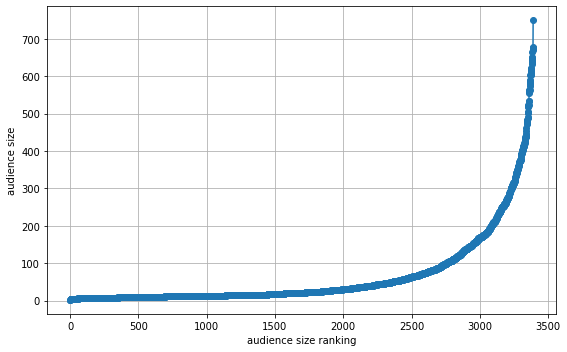

In [36]:
audience_size = np.sum(truth, axis=0)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(range(len(audience_size)), np.sort(audience_size), marker='.', linewidth=1.5, markersize=12)
ax.set_ylabel('audience size')
ax.set_xlabel('audience size ranking')
ax.grid(True)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()


In [37]:
user_list, item_list = np.where(truth > 0)
truth_df = pd.DataFrame({'uid': user_list, 'iid': item_list})

In [38]:
# count the number for each genre and sort
item_genre_dict = dict()
for i in range(len(item_df)):
    genre_str = item_df.at[i, 'genres']
    genre_list = genre_str.split('|')
    genre_overlap = set(genre_list).intersection(genres_used)
    item_genre_dict[item_df.at[i, 'iid']] = list(genre_overlap)

genre_item_count = dict()
for l in item_genre_dict:
    for g in item_genre_dict[l]:
        if not g in genre_item_count:
            genre_item_count[g] = 1
        else:
            genre_item_count[g] += 1

genre_count_sorted = sorted(genre_item_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[('Drama', 1329),
 ('Comedy', 1086),
 ('Action', 481),
 ('Thriller', 467),
 ('Romance', 427),
 ('Horror', 317),
 ('Adventure', 274),
 ('Sci-Fi', 269),
 ("Children's", 248),
 ('Crime', 190),
 ('War', 136),
 ('Musical', 108),
 ('Animation', 105),
 ('Mystery', 101),
 ('Documentary', 88),
 ('Fantasy', 67),
 ('Western', 62),
 ('Film-Noir', 41)]

In [39]:
# calculate feedback/item_count for each genre
genre_rating_count = dict()
itemIds = truth_df['iid'].values
for i in range(len(itemIds)):
    itemId = itemIds[i]
    genres = item_genre_dict[itemId]
    for g in genres:
        if not g in genre_rating_count:
            genre_rating_count[g] = 1
        else:
            genre_rating_count[g] += 1
for g in genre_item_count:
    genre_rating_count[g] /= genre_item_count[g] * 1.
genre_count_sorted = sorted(genre_rating_count.items(), key=operator.itemgetter(1), reverse=True)
genre_count_sorted

[('Sci-Fi', 131.92193308550185),
 ('War', 119.72058823529412),
 ('Fantasy', 118.46268656716418),
 ('Action', 118.37629937629937),
 ('Film-Noir', 113.48780487804878),
 ('Adventure', 108.14233576642336),
 ('Crime', 97.92631578947369),
 ('Thriller', 90.85224839400428),
 ('Mystery', 88.55445544554455),
 ('Animation', 85.85714285714286),
 ('Romance', 77.67447306791568),
 ('Comedy', 74.84714548802947),
 ('Musical', 74.20370370370371),
 ('Western', 72.37096774193549),
 ('Drama', 61.07975921745673),
 ("Children's", 58.975806451612904),
 ('Horror', 48.80757097791798),
 ('Documentary', 20.511363636363637)]

In [40]:
np.save('/content/truth.npy', truth)

In [41]:
item_df.reset_index(drop=True, inplace=True)
item_df.to_csv('/content/item_df.csv', index=False)

In [42]:
with open('/content/item_genre_dict.pkl', 'wb') as f:
    pickle.dump(item_genre_dict, f)

In [43]:
# generate list of items users like in train, warm_vali, warm_test sets for each user

num_item = len(item_list)
num_user = len(user_list)

user_truth_like = [[] for _ in range(num_user)]

for u in tqdm(user_list):
    truth_u = truth[u, :]
    truth_u_like = (np.where(truth_u > 0)[0]).astype(int)    
    user_truth_like[u] = truth_u_like
    
np.save('/content/user_truth_like.npy', np.array(user_truth_like))

100%|██████████| 221929/221929 [00:02<00:00, 110525.74it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [44]:
audience_size = np.sum(truth, axis=0)

AS_sorted = np.sort(audience_size)
num_item = len(AS_sorted)
np.sum(((np.arange(num_item) + 1.) * 2 - num_item - 1) * AS_sorted) / (num_item * np.sum(AS_sorted))

0.6452509349943383

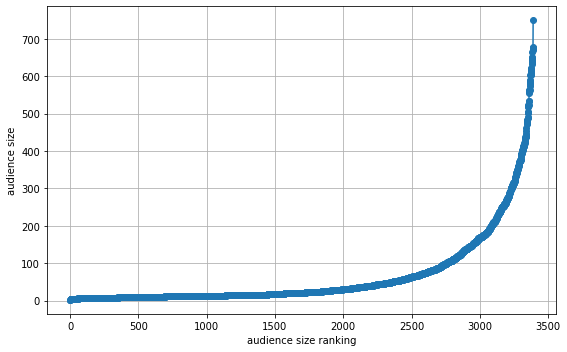

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(range(len(audience_size)), np.sort(audience_size), marker='.', linewidth=1.5, markersize=12)
ax.set_ylabel('audience size')
ax.set_xlabel('audience size ranking')
ax.grid(True)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

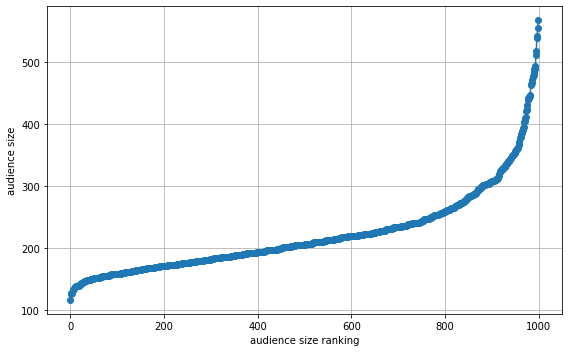

In [46]:
a = np.sum(truth, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))
ax.plot(range(len(a)), np.sort(a), marker='.', linewidth=1.5, markersize=12)
ax.set_ylabel('audience size')
ax.set_xlabel('audience size ranking')
ax.grid(True)
fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

#**Experiment_vanillaNS --> (Popular)**

In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings; warnings.simplefilter('ignore')  # Ignores Warnings for nicer Plots. Disable for Debugging
import time
import numpy as np
import argparse
from Simulation_withoutPB import Simulation


parser = argparse.ArgumentParser(description='Experiment_withoutPB')
parser.add_argument('--run', type=int, default=10, help='number of experiments to run')
parser.add_argument('--iteration', type=int, default=40000, help='number of iterations to simulate')
parser.add_argument('--exp', type=int, default=1, help='number of initial random exposure iterations')
parser.add_argument('--cycle_itr', type=int, default=50, help='number of iterations in one cycle')
parser.add_argument('--epoch', type=int, default=15, help='number of epochs to train')
parser.add_argument('--K', type=int, default=20, help='number of items to recommend')
parser.add_argument('--lr', type=float, default=0.001, help='learning rate')
parser.add_argument('--reg', type=float, default=1e-5, help='regularization')
parser.add_argument('--hidden', type=int, default=100, help='latent dimension')
parser.add_argument('--neg', type=int, default=5, help='negative sampling rate')
parser.add_argument('--data', type=str, default='ml1m', help='path to eval in the Data folder')
parser.add_argument('--num_user', type=float, default=num_user, help='path to eval in the Data folder')
parser.add_argument('--num_item', type=float, default=num_item, help='path to eval in the Data folder')
parser.add_argument('-f')

args = parser.parse_args()

truth = np.load('/content/truth.npy')
args.num_user = truth.shape[0]
args.num_item = truth.shape[1]
audience_size = np.sum(truth, axis=0)
item_sorted = np.argsort(audience_size)
truth_like = list(np.load('/content/user_truth_like.npy', allow_pickle=True))

print('')
print('!' * 30 + ' Total truth ' + str(np.sum(truth)) + ' ' + '!' * 30)
print('')

itr_cumulated_click_count_list = []
itr_GC_TPR_list = []

for r in range(args.run):
    print('')
    print('#' * 100)
    print('#' * 100)
    print(' ' * 50 + ' Experiment run ' + str(r + 1) + ' ' * 50)
    print('#' * 100)
    print('#' * 100)
    simulation = Simulation(args, truth, truth_like)
    init_popularity = simulation.initial_iterations()
    itr_click_item = simulation.run_simulation()

    itr_cumulated_click_count = []
    itr_item_click = np.zeros((args.iteration, args.num_item))
    for itr in range(args.iteration):
        click_item = itr_click_item[itr]
        itr_item_click[itr, click_item] = 1.
        itr_cumulated_click_count.append(
            len(click_item) if itr == 0 else len(click_item) + itr_cumulated_click_count[-1])
    for itr in range(1, args.iteration):
        itr_item_click[itr, :] += itr_item_click[itr - 1, :]
    itr_item_click /= (audience_size - init_popularity).reshape((1, -1))

    itr_GC_TPR = []
    for itr in range(args.iteration):
        a = itr_item_click[itr, item_sorted]
        gc = np.sum(((np.arange(len(a)) + 1.) * 2 - len(a) - 1) * a) / (len(a) * np.sum(a))
        itr_GC_TPR.append(gc)

    itr_cumulated_click_count_list.append(itr_cumulated_click_count)
    itr_GC_TPR_list.append(itr_GC_TPR)

    itr_cumulated_click_count_mean = np.mean(itr_cumulated_click_count_list, axis=0)
    itr_cumulated_click_count_std = np.std(itr_cumulated_click_count_list, axis=0)
    itr_GC_TPR_mean = np.mean(itr_GC_TPR_list, axis=0)
    itr_GC_TPR_std = np.std(itr_GC_TPR_list, axis=0)

    



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Total truth 221929.0 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


####################################################################################################
####################################################################################################
                                                   Experiment run 1                                                  
####################################################################################################
####################################################################################################
Namespace(K=20, cycle_itr=50, data='ml1m', epoch=15, exp=1, f='/root/.local/share/jupyter/runtime/kernel-25b60e66-e812-413f-88b9-4b723dd7242e.json', hidden=100, iteration=40000, lr=0.001, neg=5, num_item=3392, num_user=1000, reg=1e-05, run=10)
****************************** Start initial random iterations ******************************
---------- Iteration 1 ----------


100%|██████████| 1000/1000 [00:00<00:00, 4795.12it/s]


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Generate 448 records.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
****************************** Train MF until converge ******************************
Update bs to 53
******************************MF initialization done ******************************


100%|██████████| 51/51 [00:00<00:00, 92.76it/s] 


Training // Epoch 0 //  Total cost = 35.3839  Total cost1 = 35.3437  Total cost2 = 0.0402


100%|██████████| 51/51 [00:00<00:00, 121.47it/s]


Training // Epoch 1 //  Total cost = 35.0218  Total cost1 = 34.9949  Total cost2 = 0.0268


100%|██████████| 51/51 [00:00<00:00, 108.78it/s]


Training // Epoch 2 //  Total cost = 34.5142  Total cost1 = 34.4803  Total cost2 = 0.0339


100%|██████████| 51/51 [00:00<00:00, 118.22it/s]


Training // Epoch 3 //  Total cost = 33.6737  Total cost1 = 33.6271  Total cost2 = 0.0467


100%|██████████| 51/51 [00:00<00:00, 111.70it/s]


Training // Epoch 4 //  Total cost = 32.3923  Total cost1 = 32.3270  Total cost2 = 0.0653


100%|██████████| 51/51 [00:00<00:00, 122.92it/s]


Training // Epoch 5 //  Total cost = 30.5528  Total cost1 = 30.4619  Total cost2 = 0.0909


100%|██████████| 51/51 [00:00<00:00, 118.70it/s]


Training // Epoch 6 //  Total cost = 28.1285  Total cost1 = 28.0054  Total cost2 = 0.1231


100%|██████████| 51/51 [00:00<00:00, 122.47it/s]


Training // Epoch 7 //  Total cost = 25.0808  Total cost1 = 24.9178  Total cost2 = 0.1631


100%|██████████| 51/51 [00:00<00:00, 113.22it/s]


Training // Epoch 8 //  Total cost = 21.5580  Total cost1 = 21.3488  Total cost2 = 0.2092


100%|██████████| 51/51 [00:00<00:00, 115.22it/s]


Training // Epoch 9 //  Total cost = 17.4227  Total cost1 = 17.1587  Total cost2 = 0.2640


100%|██████████| 51/51 [00:00<00:00, 120.73it/s]


Training // Epoch 10 //  Total cost = 12.7150  Total cost1 = 12.3900  Total cost2 = 0.3250


100%|██████████| 51/51 [00:00<00:00, 116.92it/s]


Training // Epoch 11 //  Total cost = 7.5912  Total cost1 = 7.1978  Total cost2 = 0.3933


100%|██████████| 51/51 [00:00<00:00, 118.22it/s]


Training // Epoch 12 //  Total cost = 1.8966  Total cost1 = 1.4294  Total cost2 = 0.4672


100%|██████████| 51/51 [00:00<00:00, 118.78it/s]


Training // Epoch 13 //  Total cost = -3.9210  Total cost1 = -4.4696  Total cost2 = 0.5486


100%|██████████| 51/51 [00:00<00:00, 115.53it/s]


Training // Epoch 14 //  Total cost = -10.5894  Total cost1 = -11.2244  Total cost2 = 0.6350
****************************** Start simulation ******************************


100%|██████████| 50/50 [00:00<00:00, 1584.44it/s]


########## The iteration 50, up to now total 514 clicks, GC=0.8226, this cycle used 0.04 s) ##########
Update bs to 61


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1224.48it/s]


########## The iteration 100, up to now total 589 clicks, GC=0.7295, this cycle used 6.20 s) ##########
Update bs to 70


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1324.65it/s]


########## The iteration 150, up to now total 692 clicks, GC=0.6954, this cycle used 6.06 s) ##########
Update bs to 83


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1256.52it/s]


########## The iteration 200, up to now total 796 clicks, GC=0.7275, this cycle used 5.94 s) ##########
Update bs to 95


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.33it/s]


########## The iteration 250, up to now total 909 clicks, GC=0.7416, this cycle used 6.08 s) ##########
Update bs to 109


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


100%|██████████| 50/50 [00:00<00:00, 474.89it/s]


########## The iteration 300, up to now total 1033 clicks, GC=0.7563, this cycle used 7.56 s) ##########
Update bs to 123


100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


100%|██████████| 50/50 [00:00<00:00, 1412.83it/s]


########## The iteration 350, up to now total 1135 clicks, GC=0.7719, this cycle used 7.23 s) ##########
Update bs to 136


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1486.70it/s]


########## The iteration 400, up to now total 1230 clicks, GC=0.7780, this cycle used 5.94 s) ##########
Update bs to 147


100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


100%|██████████| 50/50 [00:00<00:00, 784.45it/s]


########## The iteration 450, up to now total 1354 clicks, GC=0.7893, this cycle used 5.87 s) ##########
Update bs to 162


100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1268.49it/s]


########## The iteration 500, up to now total 1490 clicks, GC=0.7918, this cycle used 5.70 s) ##########
Update bs to 178


100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1627.01it/s]


########## The iteration 550, up to now total 1597 clicks, GC=0.7983, this cycle used 5.86 s) ##########
Update bs to 191


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


100%|██████████| 50/50 [00:00<00:00, 817.11it/s]


########## The iteration 600, up to now total 1738 clicks, GC=0.7834, this cycle used 7.43 s) ##########
Update bs to 208


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.38it/s]


########## The iteration 650, up to now total 1874 clicks, GC=0.7918, this cycle used 8.01 s) ##########
Update bs to 224


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1320.81it/s]


########## The iteration 700, up to now total 2038 clicks, GC=0.7987, this cycle used 6.44 s) ##########
Update bs to 244


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1353.97it/s]


########## The iteration 750, up to now total 2196 clicks, GC=0.8028, this cycle used 6.80 s) ##########
Update bs to 263


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1669.44it/s]


########## The iteration 800, up to now total 2346 clicks, GC=0.8096, this cycle used 6.66 s) ##########
Update bs to 281


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1153.98it/s]


########## The iteration 850, up to now total 2503 clicks, GC=0.8173, this cycle used 6.62 s) ##########
Update bs to 300


100%|██████████| 15/15 [00:06<00:00,  2.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1374.02it/s]


########## The iteration 900, up to now total 2690 clicks, GC=0.8246, this cycle used 6.77 s) ##########
Update bs to 322


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1153.54it/s]


########## The iteration 950, up to now total 2861 clicks, GC=0.8164, this cycle used 6.49 s) ##########
Update bs to 343


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1978.09it/s]


########## The iteration 1000, up to now total 3036 clicks, GC=0.8232, this cycle used 6.52 s) ##########
Update bs to 364


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1173.69it/s]


########## The iteration 1050, up to now total 3182 clicks, GC=0.8277, this cycle used 6.46 s) ##########
Update bs to 381


100%|██████████| 15/15 [00:06<00:00,  2.43it/s]


100%|██████████| 50/50 [00:00<00:00, 1332.29it/s]


########## The iteration 1100, up to now total 3364 clicks, GC=0.8341, this cycle used 6.30 s) ##########
Update bs to 403


100%|██████████| 15/15 [00:06<00:00,  2.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1252.17it/s]


########## The iteration 1150, up to now total 3513 clicks, GC=0.8390, this cycle used 6.21 s) ##########
Update bs to 421


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1209.23it/s]


########## The iteration 1200, up to now total 3694 clicks, GC=0.8444, this cycle used 6.10 s) ##########
Update bs to 443


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1206.12it/s]


########## The iteration 1250, up to now total 3860 clicks, GC=0.8485, this cycle used 6.17 s) ##########
Update bs to 463


100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1221.39it/s]


########## The iteration 1300, up to now total 4009 clicks, GC=0.8325, this cycle used 6.10 s) ##########
Update bs to 481


100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1085.95it/s]


########## The iteration 1350, up to now total 4167 clicks, GC=0.8358, this cycle used 6.11 s) ##########
Update bs to 500


100%|██████████| 15/15 [00:06<00:00,  2.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1603.74it/s]


########## The iteration 1400, up to now total 4340 clicks, GC=0.8398, this cycle used 6.24 s) ##########
Update bs to 520


100%|██████████| 15/15 [00:06<00:00,  2.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1223.30it/s]


########## The iteration 1450, up to now total 4499 clicks, GC=0.8424, this cycle used 6.18 s) ##########
Update bs to 539


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


100%|██████████| 50/50 [00:00<00:00, 180.88it/s]


########## The iteration 1500, up to now total 4650 clicks, GC=0.8427, this cycle used 6.53 s) ##########
Update bs to 558


100%|██████████| 15/15 [00:06<00:00,  2.44it/s]


100%|██████████| 50/50 [00:00<00:00, 1101.31it/s]


########## The iteration 1550, up to now total 4816 clicks, GC=0.8465, this cycle used 6.30 s) ##########
Update bs to 577


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1275.44it/s]


########## The iteration 1600, up to now total 4996 clicks, GC=0.8502, this cycle used 6.52 s) ##########
Update bs to 599


100%|██████████| 15/15 [00:06<00:00,  2.40it/s]


100%|██████████| 50/50 [00:00<00:00, 1262.48it/s]


########## The iteration 1650, up to now total 5142 clicks, GC=0.8525, this cycle used 6.42 s) ##########
Update bs to 617


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1506.67it/s]


########## The iteration 1700, up to now total 5307 clicks, GC=0.8296, this cycle used 6.45 s) ##########
Update bs to 636


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1166.06it/s]


########## The iteration 1750, up to now total 5457 clicks, GC=0.8329, this cycle used 6.46 s) ##########
Update bs to 654


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1121.92it/s]


########## The iteration 1800, up to now total 5592 clicks, GC=0.8346, this cycle used 6.48 s) ##########
Update bs to 671


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


100%|██████████| 50/50 [00:00<00:00, 1186.93it/s]


########## The iteration 1850, up to now total 5741 clicks, GC=0.8344, this cycle used 6.55 s) ##########
Update bs to 688


100%|██████████| 15/15 [00:06<00:00,  2.38it/s]


100%|██████████| 50/50 [00:00<00:00, 1134.80it/s]


########## The iteration 1900, up to now total 5878 clicks, GC=0.8371, this cycle used 6.47 s) ##########
Update bs to 705


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1407.13it/s]


########## The iteration 1950, up to now total 6052 clicks, GC=0.8402, this cycle used 6.59 s) ##########
Update bs to 726


100%|██████████| 15/15 [00:06<00:00,  2.35it/s]


100%|██████████| 50/50 [00:00<00:00, 945.28it/s]


########## The iteration 2000, up to now total 6195 clicks, GC=0.8428, this cycle used 6.57 s) ##########
Update bs to 743


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1251.23it/s]


########## The iteration 2050, up to now total 6312 clicks, GC=0.8432, this cycle used 6.52 s) ##########
Update bs to 757


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1483.46it/s]


########## The iteration 2100, up to now total 6454 clicks, GC=0.8454, this cycle used 6.65 s) ##########
Update bs to 774


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.84it/s]


########## The iteration 2150, up to now total 6604 clicks, GC=0.8477, this cycle used 6.62 s) ##########
Update bs to 792


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1079.86it/s]


########## The iteration 2200, up to now total 6760 clicks, GC=0.8498, this cycle used 6.66 s) ##########
Update bs to 811


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1095.75it/s]


########## The iteration 2250, up to now total 6896 clicks, GC=0.8472, this cycle used 6.75 s) ##########
Update bs to 827


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1214.70it/s]


########## The iteration 2300, up to now total 7029 clicks, GC=0.8492, this cycle used 6.65 s) ##########
Update bs to 843


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1508.15it/s]


########## The iteration 2350, up to now total 7181 clicks, GC=0.8497, this cycle used 6.50 s) ##########
Update bs to 861


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


100%|██████████| 50/50 [00:00<00:00, 1356.65it/s]


########## The iteration 2400, up to now total 7315 clicks, GC=0.8513, this cycle used 6.53 s) ##########
Update bs to 877


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1190.14it/s]


########## The iteration 2450, up to now total 7450 clicks, GC=0.8515, this cycle used 6.54 s) ##########
Update bs to 894


100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


100%|██████████| 50/50 [00:00<00:00, 1554.19it/s]


########## The iteration 2500, up to now total 7604 clicks, GC=0.8457, this cycle used 6.52 s) ##########
Update bs to 912


100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


100%|██████████| 50/50 [00:00<00:00, 985.32it/s]


########## The iteration 2550, up to now total 7749 clicks, GC=0.8472, this cycle used 6.52 s) ##########
Update bs to 929


100%|██████████| 15/15 [00:06<00:00,  2.39it/s]


100%|██████████| 50/50 [00:00<00:00, 1258.00it/s]


########## The iteration 2600, up to now total 7890 clicks, GC=0.8416, this cycle used 6.44 s) ##########
Update bs to 946


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1292.88it/s]


########## The iteration 2650, up to now total 8028 clicks, GC=0.8424, this cycle used 6.65 s) ##########
Update bs to 963


100%|██████████| 15/15 [00:06<00:00,  2.34it/s]


100%|██████████| 50/50 [00:00<00:00, 1586.95it/s]


########## The iteration 2700, up to now total 8190 clicks, GC=0.8334, this cycle used 6.60 s) ##########
Update bs to 982


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1212.61it/s]


########## The iteration 2750, up to now total 8331 clicks, GC=0.8353, this cycle used 6.70 s) ##########
Update bs to 999


100%|██████████| 15/15 [00:06<00:00,  2.31it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.58it/s]


########## The iteration 2800, up to now total 8477 clicks, GC=0.8368, this cycle used 6.70 s) ##########
Update bs to 1017


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.93it/s]


########## The iteration 2850, up to now total 8615 clicks, GC=0.8378, this cycle used 6.62 s) ##########
Update bs to 1033


100%|██████████| 15/15 [00:06<00:00,  2.32it/s]


100%|██████████| 50/50 [00:00<00:00, 1164.64it/s]


########## The iteration 2900, up to now total 8770 clicks, GC=0.8398, this cycle used 6.66 s) ##########
Update bs to 1052


100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1163.55it/s]


########## The iteration 2950, up to now total 8904 clicks, GC=0.8409, this cycle used 6.83 s) ##########
Update bs to 1068


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.37it/s]


########## The iteration 3000, up to now total 9026 clicks, GC=0.8418, this cycle used 6.90 s) ##########
Update bs to 1083


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


100%|██████████| 50/50 [00:00<00:00, 985.09it/s]


########## The iteration 3050, up to now total 9164 clicks, GC=0.8406, this cycle used 6.92 s) ##########
Update bs to 1099


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1089.20it/s]


########## The iteration 3100, up to now total 9323 clicks, GC=0.8420, this cycle used 6.92 s) ##########
Update bs to 1118


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1224.64it/s]


########## The iteration 3150, up to now total 9469 clicks, GC=0.8398, this cycle used 6.75 s) ##########
Update bs to 1136


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1165.69it/s]


########## The iteration 3200, up to now total 9579 clicks, GC=0.8407, this cycle used 6.71 s) ##########
Update bs to 1149


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


100%|██████████| 50/50 [00:00<00:00, 986.86it/s]


########## The iteration 3250, up to now total 9730 clicks, GC=0.8423, this cycle used 6.84 s) ##########
Update bs to 1167


100%|██████████| 15/15 [00:06<00:00,  2.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1327.22it/s]


########## The iteration 3300, up to now total 9865 clicks, GC=0.8436, this cycle used 6.77 s) ##########
Update bs to 1183


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1386.63it/s]


########## The iteration 3350, up to now total 10007 clicks, GC=0.8445, this cycle used 6.97 s) ##########
Update bs to 1200


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1106.72it/s]


########## The iteration 3400, up to now total 10128 clicks, GC=0.8457, this cycle used 6.89 s) ##########
Update bs to 1215


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1001.63it/s]


########## The iteration 3450, up to now total 10280 clicks, GC=0.8469, this cycle used 6.98 s) ##########
Update bs to 1233


100%|██████████| 15/15 [00:06<00:00,  2.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1390.32it/s]


########## The iteration 3500, up to now total 10395 clicks, GC=0.8477, this cycle used 6.86 s) ##########
Update bs to 1247


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1196.46it/s]


########## The iteration 3550, up to now total 10513 clicks, GC=0.8488, this cycle used 6.89 s) ##########
Update bs to 1261


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


100%|██████████| 50/50 [00:00<00:00, 940.84it/s]


########## The iteration 3600, up to now total 10638 clicks, GC=0.8421, this cycle used 7.02 s) ##########
Update bs to 1276


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1136.66it/s]


########## The iteration 3650, up to now total 10763 clicks, GC=0.8428, this cycle used 7.02 s) ##########
Update bs to 1291


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]


100%|██████████| 50/50 [00:00<00:00, 1211.68it/s]


########## The iteration 3700, up to now total 10901 clicks, GC=0.8367, this cycle used 6.91 s) ##########
Update bs to 1308


100%|██████████| 15/15 [00:06<00:00,  2.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1195.55it/s]


########## The iteration 3750, up to now total 11047 clicks, GC=0.8376, this cycle used 6.99 s) ##########
Update bs to 1325


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1584.62it/s]


########## The iteration 3800, up to now total 11167 clicks, GC=0.8381, this cycle used 6.98 s) ##########
Update bs to 1340


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 991.84it/s]


########## The iteration 3850, up to now total 11293 clicks, GC=0.8375, this cycle used 7.17 s) ##########
Update bs to 1355


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1020.19it/s]


########## The iteration 3900, up to now total 11412 clicks, GC=0.8385, this cycle used 7.15 s) ##########
Update bs to 1369


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1355.01it/s]


########## The iteration 3950, up to now total 11540 clicks, GC=0.8396, this cycle used 7.17 s) ##########
Update bs to 1384


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1271.93it/s]


########## The iteration 4000, up to now total 11661 clicks, GC=0.8407, this cycle used 7.15 s) ##########
Update bs to 1399


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1330.22it/s]


########## The iteration 4050, up to now total 11771 clicks, GC=0.8417, this cycle used 7.14 s) ##########
Update bs to 1412


100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1024.09it/s]


########## The iteration 4100, up to now total 11907 clicks, GC=0.8429, this cycle used 6.91 s) ##########
Update bs to 1428


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


100%|██████████| 50/50 [00:00<00:00, 1470.35it/s]


########## The iteration 4150, up to now total 12033 clicks, GC=0.8435, this cycle used 6.95 s) ##########
Update bs to 1443


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1193.80it/s]


########## The iteration 4200, up to now total 12144 clicks, GC=0.8442, this cycle used 7.06 s) ##########
Update bs to 1457


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


100%|██████████| 50/50 [00:00<00:00, 1077.75it/s]


########## The iteration 4250, up to now total 12263 clicks, GC=0.8440, this cycle used 7.02 s) ##########
Update bs to 1471


100%|██████████| 15/15 [00:06<00:00,  2.20it/s]


100%|██████████| 50/50 [00:00<00:00, 952.29it/s]


########## The iteration 4300, up to now total 12384 clicks, GC=0.8450, this cycle used 7.03 s) ##########
Update bs to 1486


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1057.30it/s]


########## The iteration 4350, up to now total 12525 clicks, GC=0.8444, this cycle used 7.17 s) ##########
Update bs to 1503


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.38it/s]


########## The iteration 4400, up to now total 12652 clicks, GC=0.8422, this cycle used 7.10 s) ##########
Update bs to 1518


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


100%|██████████| 50/50 [00:00<00:00, 966.22it/s]


########## The iteration 4450, up to now total 12787 clicks, GC=0.8433, this cycle used 7.10 s) ##########
Update bs to 1534


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1131.61it/s]


########## The iteration 4500, up to now total 12926 clicks, GC=0.8411, this cycle used 7.08 s) ##########
Update bs to 1551


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1114.80it/s]


########## The iteration 4550, up to now total 13059 clicks, GC=0.8422, this cycle used 7.18 s) ##########
Update bs to 1567


100%|██████████| 15/15 [00:06<00:00,  2.18it/s]


100%|██████████| 50/50 [00:00<00:00, 1097.71it/s]


########## The iteration 4600, up to now total 13188 clicks, GC=0.8356, this cycle used 7.09 s) ##########
Update bs to 1582


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1279.84it/s]


########## The iteration 4650, up to now total 13297 clicks, GC=0.8362, this cycle used 7.23 s) ##########
Update bs to 1595


100%|██████████| 15/15 [00:06<00:00,  2.19it/s]


100%|██████████| 50/50 [00:00<00:00, 1096.31it/s]


########## The iteration 4700, up to now total 13390 clicks, GC=0.8369, this cycle used 7.07 s) ##########
Update bs to 1606


100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


100%|██████████| 50/50 [00:00<00:00, 1008.79it/s]


########## The iteration 4750, up to now total 13495 clicks, GC=0.8306, this cycle used 7.19 s) ##########
Update bs to 1619


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


100%|██████████| 50/50 [00:00<00:00, 955.75it/s]


########## The iteration 4800, up to now total 13615 clicks, GC=0.8314, this cycle used 7.14 s) ##########
Update bs to 1633


100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


100%|██████████| 50/50 [00:00<00:00, 906.52it/s]


########## The iteration 4850, up to now total 13715 clicks, GC=0.8321, this cycle used 7.26 s) ##########
Update bs to 1645


100%|██████████| 15/15 [00:07<00:00,  2.14it/s]


100%|██████████| 50/50 [00:00<00:00, 1097.64it/s]


########## The iteration 4900, up to now total 13841 clicks, GC=0.8331, this cycle used 7.24 s) ##########
Update bs to 1660


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1072.13it/s]


########## The iteration 4950, up to now total 13956 clicks, GC=0.8336, this cycle used 7.36 s) ##########
Update bs to 1674


100%|██████████| 15/15 [00:07<00:00,  2.13it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.34it/s]


########## The iteration 5000, up to now total 14077 clicks, GC=0.8346, this cycle used 7.27 s) ##########
Update bs to 1689


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1002.27it/s]


########## The iteration 5050, up to now total 14218 clicks, GC=0.8354, this cycle used 7.53 s) ##########
Update bs to 1706


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


100%|██████████| 50/50 [00:00<00:00, 1205.25it/s]


########## The iteration 5100, up to now total 14348 clicks, GC=0.8360, this cycle used 7.42 s) ##########
Update bs to 1721


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1419.49it/s]


########## The iteration 5150, up to now total 14454 clicks, GC=0.8363, this cycle used 7.62 s) ##########
Update bs to 1734


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.55it/s]


########## The iteration 5200, up to now total 14563 clicks, GC=0.8344, this cycle used 7.54 s) ##########
Update bs to 1747


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1341.63it/s]


########## The iteration 5250, up to now total 14682 clicks, GC=0.8333, this cycle used 7.70 s) ##########
Update bs to 1761


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1458.38it/s]


########## The iteration 5300, up to now total 14784 clicks, GC=0.8339, this cycle used 7.48 s) ##########
Update bs to 1774


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


100%|██████████| 50/50 [00:00<00:00, 1200.97it/s]


########## The iteration 5350, up to now total 14917 clicks, GC=0.8343, this cycle used 7.61 s) ##########
Update bs to 1790


100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


100%|██████████| 50/50 [00:00<00:00, 1467.66it/s]


########## The iteration 5400, up to now total 15032 clicks, GC=0.8350, this cycle used 7.37 s) ##########
Update bs to 1803


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1060.46it/s]


########## The iteration 5450, up to now total 15157 clicks, GC=0.8351, this cycle used 7.59 s) ##########
Update bs to 1818


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1073.70it/s]


########## The iteration 5500, up to now total 15288 clicks, GC=0.8360, this cycle used 7.50 s) ##########
Update bs to 1834


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1373.12it/s]


########## The iteration 5550, up to now total 15407 clicks, GC=0.8365, this cycle used 7.67 s) ##########
Update bs to 1848


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1217.43it/s]


########## The iteration 5600, up to now total 15535 clicks, GC=0.8373, this cycle used 7.57 s) ##########
Update bs to 1864


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1006.25it/s]


########## The iteration 5650, up to now total 15647 clicks, GC=0.8381, this cycle used 7.79 s) ##########
Update bs to 1877


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.23it/s]


########## The iteration 5700, up to now total 15791 clicks, GC=0.8387, this cycle used 7.53 s) ##########
Update bs to 1894


100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.06it/s]


########## The iteration 5750, up to now total 15927 clicks, GC=0.8393, this cycle used 7.44 s) ##########
Update bs to 1911


100%|██████████| 15/15 [00:07<00:00,  2.08it/s]


100%|██████████| 50/50 [00:00<00:00, 944.26it/s]


########## The iteration 5800, up to now total 16057 clicks, GC=0.8345, this cycle used 7.45 s) ##########
Update bs to 1926


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1199.05it/s]


########## The iteration 5850, up to now total 16173 clicks, GC=0.8353, this cycle used 7.47 s) ##########
Update bs to 1940


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


100%|██████████| 50/50 [00:00<00:00, 1082.06it/s]


########## The iteration 5900, up to now total 16311 clicks, GC=0.8360, this cycle used 7.49 s) ##########
Update bs to 1957


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


100%|██████████| 50/50 [00:00<00:00, 884.55it/s]


########## The iteration 5950, up to now total 16426 clicks, GC=0.8368, this cycle used 7.41 s) ##########
Update bs to 1971


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1113.52it/s]


########## The iteration 6000, up to now total 16535 clicks, GC=0.8372, this cycle used 7.64 s) ##########
Update bs to 1984


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.53it/s]


########## The iteration 6050, up to now total 16652 clicks, GC=0.8379, this cycle used 7.58 s) ##########
Update bs to 1998


100%|██████████| 15/15 [00:07<00:00,  2.02it/s]


100%|██████████| 50/50 [00:00<00:00, 1058.49it/s]


########## The iteration 6100, up to now total 16783 clicks, GC=0.8383, this cycle used 7.66 s) ##########
Update bs to 2013


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


100%|██████████| 50/50 [00:00<00:00, 1047.54it/s]


########## The iteration 6150, up to now total 16889 clicks, GC=0.8386, this cycle used 7.55 s) ##########
Update bs to 2026


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1284.31it/s]


########## The iteration 6200, up to now total 16992 clicks, GC=0.8391, this cycle used 7.55 s) ##########
Update bs to 2039


100%|██████████| 15/15 [00:07<00:00,  2.05it/s]


100%|██████████| 50/50 [00:00<00:00, 996.44it/s]


########## The iteration 6250, up to now total 17121 clicks, GC=0.8398, this cycle used 7.54 s) ##########
Update bs to 2054


100%|██████████| 15/15 [00:07<00:00,  2.07it/s]


100%|██████████| 50/50 [00:00<00:00, 965.15it/s]


########## The iteration 6300, up to now total 17242 clicks, GC=0.8392, this cycle used 7.49 s) ##########
Update bs to 2069


100%|██████████| 15/15 [00:07<00:00,  2.03it/s]


100%|██████████| 50/50 [00:00<00:00, 990.62it/s]


########## The iteration 6350, up to now total 17356 clicks, GC=0.8393, this cycle used 7.66 s) ##########
Update bs to 2082


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1003.84it/s]


########## The iteration 6400, up to now total 17471 clicks, GC=0.8394, this cycle used 7.74 s) ##########
Update bs to 2096


100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


100%|██████████| 50/50 [00:00<00:00, 1004.41it/s]


########## The iteration 6450, up to now total 17575 clicks, GC=0.8394, this cycle used 7.53 s) ##########
Update bs to 2109


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1000.40it/s]


########## The iteration 6500, up to now total 17692 clicks, GC=0.8400, this cycle used 7.75 s) ##########
Update bs to 2123


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 877.04it/s]


########## The iteration 6550, up to now total 17807 clicks, GC=0.8406, this cycle used 7.92 s) ##########
Update bs to 2136


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


100%|██████████| 50/50 [00:00<00:00, 939.08it/s]


########## The iteration 6600, up to now total 17916 clicks, GC=0.8411, this cycle used 7.84 s) ##########
Update bs to 2149


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 981.60it/s]


########## The iteration 6650, up to now total 18038 clicks, GC=0.8418, this cycle used 7.88 s) ##########
Update bs to 2164


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1222.67it/s]


########## The iteration 6700, up to now total 18160 clicks, GC=0.8423, this cycle used 7.85 s) ##########
Update bs to 2179


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.62it/s]


########## The iteration 6750, up to now total 18274 clicks, GC=0.8425, this cycle used 7.79 s) ##########
Update bs to 2192


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1276.28it/s]


########## The iteration 6800, up to now total 18378 clicks, GC=0.8430, this cycle used 7.86 s) ##########
Update bs to 2205


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 728.43it/s]


########## The iteration 6850, up to now total 18504 clicks, GC=0.8437, this cycle used 7.93 s) ##########
Update bs to 2220


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


100%|██████████| 50/50 [00:00<00:00, 899.96it/s]


########## The iteration 6900, up to now total 18632 clicks, GC=0.8443, this cycle used 7.84 s) ##########
Update bs to 2235


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1351.12it/s]


########## The iteration 6950, up to now total 18731 clicks, GC=0.8447, this cycle used 7.85 s) ##########
Update bs to 2247


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1155.88it/s]


########## The iteration 7000, up to now total 18836 clicks, GC=0.8452, this cycle used 7.98 s) ##########
Update bs to 2260


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


100%|██████████| 50/50 [00:00<00:00, 838.78it/s]


########## The iteration 7050, up to now total 18954 clicks, GC=0.8453, this cycle used 7.88 s) ##########
Update bs to 2274


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 984.40it/s]


########## The iteration 7100, up to now total 19066 clicks, GC=0.8457, this cycle used 7.91 s) ##########
Update bs to 2287


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 932.24it/s]


########## The iteration 7150, up to now total 19178 clicks, GC=0.8462, this cycle used 7.90 s) ##########
Update bs to 2301


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 888.00it/s]


########## The iteration 7200, up to now total 19279 clicks, GC=0.8467, this cycle used 7.92 s) ##########
Update bs to 2313


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1156.05it/s]


########## The iteration 7250, up to now total 19393 clicks, GC=0.8469, this cycle used 7.87 s) ##########
Update bs to 2327


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


100%|██████████| 50/50 [00:00<00:00, 950.64it/s]


########## The iteration 7300, up to now total 19503 clicks, GC=0.8456, this cycle used 7.77 s) ##########
Update bs to 2340


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


100%|██████████| 50/50 [00:00<00:00, 1155.83it/s]


########## The iteration 7350, up to now total 19606 clicks, GC=0.8460, this cycle used 7.76 s) ##########
Update bs to 2352


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1019.63it/s]


########## The iteration 7400, up to now total 19702 clicks, GC=0.8464, this cycle used 8.38 s) ##########
Update bs to 2364


100%|██████████| 15/15 [00:07<00:00,  1.98it/s]


100%|██████████| 50/50 [00:00<00:00, 887.35it/s]


########## The iteration 7450, up to now total 19845 clicks, GC=0.8464, this cycle used 7.81 s) ##########
Update bs to 2381


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


100%|██████████| 50/50 [00:00<00:00, 810.20it/s]


########## The iteration 7500, up to now total 19960 clicks, GC=0.8466, this cycle used 8.05 s) ##########
Update bs to 2395


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


100%|██████████| 50/50 [00:00<00:00, 866.17it/s]


########## The iteration 7550, up to now total 20074 clicks, GC=0.8469, this cycle used 8.16 s) ##########
Update bs to 2408


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


100%|██████████| 50/50 [00:00<00:00, 1053.84it/s]


########## The iteration 7600, up to now total 20192 clicks, GC=0.8474, this cycle used 7.99 s) ##########
Update bs to 2423


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


100%|██████████| 50/50 [00:00<00:00, 990.01it/s]


########## The iteration 7650, up to now total 20316 clicks, GC=0.8477, this cycle used 7.99 s) ##########
Update bs to 2437


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.85it/s]


########## The iteration 7700, up to now total 20438 clicks, GC=0.8477, this cycle used 7.90 s) ##########
Update bs to 2452


100%|██████████| 15/15 [00:07<00:00,  1.94it/s]


100%|██████████| 50/50 [00:00<00:00, 782.79it/s]


########## The iteration 7750, up to now total 20555 clicks, GC=0.8478, this cycle used 7.99 s) ##########
Update bs to 2466


100%|██████████| 15/15 [00:07<00:00,  1.97it/s]


100%|██████████| 50/50 [00:00<00:00, 973.68it/s]


########## The iteration 7800, up to now total 20689 clicks, GC=0.8484, this cycle used 7.89 s) ##########
Update bs to 2482


100%|██████████| 15/15 [00:07<00:00,  1.96it/s]


100%|██████████| 50/50 [00:00<00:00, 873.98it/s]


########## The iteration 7850, up to now total 20797 clicks, GC=0.8486, this cycle used 7.92 s) ##########
Update bs to 2495


100%|██████████| 15/15 [00:07<00:00,  1.95it/s]


100%|██████████| 50/50 [00:00<00:00, 1119.66it/s]


########## The iteration 7900, up to now total 20901 clicks, GC=0.8490, this cycle used 7.96 s) ##########
Update bs to 2508


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


100%|██████████| 50/50 [00:00<00:00, 900.46it/s]


########## The iteration 7950, up to now total 21010 clicks, GC=0.8495, this cycle used 8.10 s) ##########
Update bs to 2521


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


100%|██████████| 50/50 [00:00<00:00, 801.76it/s]


########## The iteration 8000, up to now total 21134 clicks, GC=0.8500, this cycle used 8.14 s) ##########
Update bs to 2536


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


100%|██████████| 50/50 [00:00<00:00, 886.51it/s]


########## The iteration 8050, up to now total 21237 clicks, GC=0.8505, this cycle used 8.12 s) ##########
Update bs to 2548


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


100%|██████████| 50/50 [00:00<00:00, 970.49it/s]


########## The iteration 8100, up to now total 21354 clicks, GC=0.8509, this cycle used 8.16 s) ##########
Update bs to 2562


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


100%|██████████| 50/50 [00:00<00:00, 847.20it/s]


########## The iteration 8150, up to now total 21454 clicks, GC=0.8512, this cycle used 8.13 s) ##########
Update bs to 2574


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 822.68it/s]


########## The iteration 8200, up to now total 21572 clicks, GC=0.8510, this cycle used 8.31 s) ##########
Update bs to 2588


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 845.85it/s]


########## The iteration 8250, up to now total 21674 clicks, GC=0.8514, this cycle used 8.29 s) ##########
Update bs to 2600


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 869.65it/s]


########## The iteration 8300, up to now total 21804 clicks, GC=0.8517, this cycle used 8.29 s) ##########
Update bs to 2616


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1094.06it/s]


########## The iteration 8350, up to now total 21903 clicks, GC=0.8519, this cycle used 8.28 s) ##########
Update bs to 2628


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


100%|██████████| 50/50 [00:00<00:00, 913.91it/s]


########## The iteration 8400, up to now total 22005 clicks, GC=0.8520, this cycle used 8.28 s) ##########
Update bs to 2640


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.94it/s]


########## The iteration 8450, up to now total 22120 clicks, GC=0.8523, this cycle used 8.05 s) ##########
Update bs to 2654


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 855.54it/s]


########## The iteration 8500, up to now total 22234 clicks, GC=0.8493, this cycle used 8.33 s) ##########
Update bs to 2668


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1140.77it/s]


########## The iteration 8550, up to now total 22352 clicks, GC=0.8497, this cycle used 8.34 s) ##########
Update bs to 2682


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.00it/s]


########## The iteration 8600, up to now total 22455 clicks, GC=0.8501, this cycle used 8.35 s) ##########
Update bs to 2694


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 785.53it/s]


########## The iteration 8650, up to now total 22565 clicks, GC=0.8502, this cycle used 8.35 s) ##########
Update bs to 2707


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


100%|██████████| 50/50 [00:00<00:00, 752.27it/s]


########## The iteration 8700, up to now total 22668 clicks, GC=0.8502, this cycle used 8.28 s) ##########
Update bs to 2720


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


100%|██████████| 50/50 [00:00<00:00, 996.64it/s]


########## The iteration 8750, up to now total 22771 clicks, GC=0.8505, this cycle used 8.19 s) ##########
Update bs to 2732


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


100%|██████████| 50/50 [00:00<00:00, 910.76it/s]


########## The iteration 8800, up to now total 22870 clicks, GC=0.8509, this cycle used 8.12 s) ##########
Update bs to 2744


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


100%|██████████| 50/50 [00:00<00:00, 854.71it/s]


########## The iteration 8850, up to now total 22972 clicks, GC=0.8512, this cycle used 8.22 s) ##########
Update bs to 2756


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


100%|██████████| 50/50 [00:00<00:00, 992.58it/s]


########## The iteration 8900, up to now total 23075 clicks, GC=0.8514, this cycle used 8.24 s) ##########
Update bs to 2769


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1208.95it/s]


########## The iteration 8950, up to now total 23189 clicks, GC=0.8518, this cycle used 8.27 s) ##########
Update bs to 2782


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1151.64it/s]


########## The iteration 9000, up to now total 23317 clicks, GC=0.8522, this cycle used 8.30 s) ##########
Update bs to 2798


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


100%|██████████| 50/50 [00:00<00:00, 960.40it/s]


########## The iteration 9050, up to now total 23429 clicks, GC=0.8525, this cycle used 8.26 s) ##########
Update bs to 2811


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 841.53it/s]


########## The iteration 9100, up to now total 23540 clicks, GC=0.8526, this cycle used 8.36 s) ##########
Update bs to 2824


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.54it/s]


########## The iteration 9150, up to now total 23648 clicks, GC=0.8528, this cycle used 8.45 s) ##########
Update bs to 2837


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


100%|██████████| 50/50 [00:00<00:00, 878.91it/s]


########## The iteration 9200, up to now total 23759 clicks, GC=0.8532, this cycle used 8.24 s) ##########
Update bs to 2851


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


100%|██████████| 50/50 [00:00<00:00, 979.28it/s]


########## The iteration 9250, up to now total 23874 clicks, GC=0.8535, this cycle used 8.17 s) ##########
Update bs to 2864


100%|██████████| 15/15 [00:07<00:00,  1.92it/s]


100%|██████████| 50/50 [00:00<00:00, 954.78it/s]


########## The iteration 9300, up to now total 23983 clicks, GC=0.8538, this cycle used 8.08 s) ##########
Update bs to 2877


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


100%|██████████| 50/50 [00:00<00:00, 781.88it/s]


########## The iteration 9350, up to now total 24085 clicks, GC=0.8541, this cycle used 8.25 s) ##########
Update bs to 2890


100%|██████████| 15/15 [00:07<00:00,  1.88it/s]


100%|██████████| 50/50 [00:00<00:00, 1006.00it/s]


########## The iteration 9400, up to now total 24179 clicks, GC=0.8531, this cycle used 8.29 s) ##########
Update bs to 2901


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 1287.16it/s]


########## The iteration 9450, up to now total 24295 clicks, GC=0.8533, this cycle used 8.32 s) ##########
Update bs to 2915


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 803.06it/s]


########## The iteration 9500, up to now total 24418 clicks, GC=0.8537, this cycle used 8.34 s) ##########
Update bs to 2930


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


100%|██████████| 50/50 [00:00<00:00, 943.91it/s]


########## The iteration 9550, up to now total 24515 clicks, GC=0.8539, this cycle used 8.41 s) ##########
Update bs to 2941


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 904.49it/s]


########## The iteration 9600, up to now total 24631 clicks, GC=0.8542, this cycle used 8.29 s) ##########
Update bs to 2955


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


100%|██████████| 50/50 [00:00<00:00, 1137.80it/s]


########## The iteration 9650, up to now total 24729 clicks, GC=0.8544, this cycle used 8.41 s) ##########
Update bs to 2967


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1041.01it/s]


########## The iteration 9700, up to now total 24853 clicks, GC=0.8548, this cycle used 8.47 s) ##########
Update bs to 2982


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


100%|██████████| 50/50 [00:00<00:00, 858.15it/s]


########## The iteration 9750, up to now total 24962 clicks, GC=0.8551, this cycle used 8.46 s) ##########
Update bs to 2995


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 857.64it/s]


########## The iteration 9800, up to now total 25082 clicks, GC=0.8554, this cycle used 8.53 s) ##########
Update bs to 3009


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 902.05it/s]


########## The iteration 9850, up to now total 25177 clicks, GC=0.8556, this cycle used 8.54 s) ##########
Update bs to 3021


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 900.27it/s]


########## The iteration 9900, up to now total 25283 clicks, GC=0.8559, this cycle used 8.52 s) ##########
Update bs to 3033


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


100%|██████████| 50/50 [00:00<00:00, 998.67it/s]


########## The iteration 9950, up to now total 25396 clicks, GC=0.8562, this cycle used 8.52 s) ##########
Update bs to 3047


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 1042.48it/s]


########## The iteration 10000, up to now total 25489 clicks, GC=0.8564, this cycle used 8.51 s) ##########
Update bs to 3058


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


100%|██████████| 50/50 [00:00<00:00, 907.27it/s]


########## The iteration 10050, up to now total 25606 clicks, GC=0.8567, this cycle used 8.44 s) ##########
Update bs to 3072


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


100%|██████████| 50/50 [00:00<00:00, 901.06it/s]


########## The iteration 10100, up to now total 25716 clicks, GC=0.8554, this cycle used 8.49 s) ##########
Update bs to 3085


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


100%|██████████| 50/50 [00:00<00:00, 985.58it/s]


########## The iteration 10150, up to now total 25816 clicks, GC=0.8556, this cycle used 8.46 s) ##########
Update bs to 3097


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1138.27it/s]


########## The iteration 10200, up to now total 25943 clicks, GC=0.8559, this cycle used 8.45 s) ##########
Update bs to 3113


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 858.02it/s]


########## The iteration 10250, up to now total 26051 clicks, GC=0.8561, this cycle used 8.35 s) ##########
Update bs to 3126


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 785.20it/s]


########## The iteration 10300, up to now total 26138 clicks, GC=0.8562, this cycle used 8.53 s) ##########
Update bs to 3136


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 766.45it/s]


########## The iteration 10350, up to now total 26259 clicks, GC=0.8566, this cycle used 8.38 s) ##########
Update bs to 3151


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 900.68it/s]


########## The iteration 10400, up to now total 26362 clicks, GC=0.8568, this cycle used 8.52 s) ##########
Update bs to 3163


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


100%|██████████| 50/50 [00:00<00:00, 809.77it/s]


########## The iteration 10450, up to now total 26465 clicks, GC=0.8569, this cycle used 8.40 s) ##########
Update bs to 3175


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 936.94it/s]


########## The iteration 10500, up to now total 26586 clicks, GC=0.8571, this cycle used 8.34 s) ##########
Update bs to 3190


100%|██████████| 15/15 [00:08<00:00,  1.87it/s]


100%|██████████| 50/50 [00:00<00:00, 896.86it/s]


########## The iteration 10550, up to now total 26703 clicks, GC=0.8573, this cycle used 8.30 s) ##########
Update bs to 3204


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


100%|██████████| 50/50 [00:00<00:00, 963.08it/s]


########## The iteration 10600, up to now total 26813 clicks, GC=0.8565, this cycle used 8.42 s) ##########
Update bs to 3217


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 1169.28it/s]


########## The iteration 10650, up to now total 26913 clicks, GC=0.8566, this cycle used 8.36 s) ##########
Update bs to 3229


100%|██████████| 15/15 [00:07<00:00,  1.89it/s]


100%|██████████| 50/50 [00:00<00:00, 162.23it/s]


########## The iteration 10700, up to now total 27024 clicks, GC=0.8566, this cycle used 8.53 s) ##########
Update bs to 3242


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


100%|██████████| 50/50 [00:00<00:00, 806.62it/s]


########## The iteration 10750, up to now total 27114 clicks, GC=0.8568, this cycle used 8.36 s) ##########
Update bs to 3253


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.67it/s]


########## The iteration 10800, up to now total 27226 clicks, GC=0.8571, this cycle used 8.47 s) ##########
Update bs to 3267


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


100%|██████████| 50/50 [00:00<00:00, 996.63it/s]


########## The iteration 10850, up to now total 27332 clicks, GC=0.8566, this cycle used 8.51 s) ##########
Update bs to 3279


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


100%|██████████| 50/50 [00:00<00:00, 798.00it/s]


########## The iteration 10900, up to now total 27450 clicks, GC=0.8568, this cycle used 8.88 s) ##########
Update bs to 3294


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


100%|██████████| 50/50 [00:00<00:00, 863.75it/s]


########## The iteration 10950, up to now total 27542 clicks, GC=0.8571, this cycle used 8.86 s) ##########
Update bs to 3305


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


100%|██████████| 50/50 [00:00<00:00, 918.46it/s]


########## The iteration 11000, up to now total 27641 clicks, GC=0.8573, this cycle used 8.77 s) ##########
Update bs to 3316


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 876.89it/s]


########## The iteration 11050, up to now total 27743 clicks, GC=0.8575, this cycle used 8.59 s) ##########
Update bs to 3329


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


100%|██████████| 50/50 [00:00<00:00, 880.40it/s]


########## The iteration 11100, up to now total 27852 clicks, GC=0.8577, this cycle used 8.74 s) ##########
Update bs to 3342


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


100%|██████████| 50/50 [00:00<00:00, 871.56it/s]


########## The iteration 11150, up to now total 27960 clicks, GC=0.8579, this cycle used 8.78 s) ##########
Update bs to 3355


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1074.67it/s]


########## The iteration 11200, up to now total 28066 clicks, GC=0.8580, this cycle used 8.89 s) ##########
Update bs to 3367


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


100%|██████████| 50/50 [00:00<00:00, 798.48it/s]


########## The iteration 11250, up to now total 28170 clicks, GC=0.8582, this cycle used 8.81 s) ##########
Update bs to 3380


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1154.97it/s]


########## The iteration 11300, up to now total 28252 clicks, GC=0.8583, this cycle used 8.59 s) ##########
Update bs to 3390


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


100%|██████████| 50/50 [00:00<00:00, 866.83it/s]


########## The iteration 11350, up to now total 28357 clicks, GC=0.8585, this cycle used 8.74 s) ##########
Update bs to 3402


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


100%|██████████| 50/50 [00:00<00:00, 943.69it/s]


########## The iteration 11400, up to now total 28457 clicks, GC=0.8586, this cycle used 8.76 s) ##########
Update bs to 3414


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 679.37it/s]


########## The iteration 11450, up to now total 28564 clicks, GC=0.8588, this cycle used 8.64 s) ##########
Update bs to 3427


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


100%|██████████| 50/50 [00:00<00:00, 921.66it/s]


########## The iteration 11500, up to now total 28661 clicks, GC=0.8590, this cycle used 8.91 s) ##########
Update bs to 3439


100%|██████████| 15/15 [00:08<00:00,  1.78it/s]


100%|██████████| 50/50 [00:00<00:00, 856.06it/s]


########## The iteration 11550, up to now total 28746 clicks, GC=0.8586, this cycle used 8.77 s) ##########
Update bs to 3449


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


100%|██████████| 50/50 [00:00<00:00, 974.65it/s]


########## The iteration 11600, up to now total 28847 clicks, GC=0.8585, this cycle used 8.88 s) ##########
Update bs to 3461


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1069.15it/s]


########## The iteration 11650, up to now total 28960 clicks, GC=0.8588, this cycle used 8.93 s) ##########
Update bs to 3475


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1080.85it/s]


########## The iteration 11700, up to now total 29073 clicks, GC=0.8588, this cycle used 8.61 s) ##########
Update bs to 3488


100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


100%|██████████| 50/50 [00:00<00:00, 754.47it/s]


########## The iteration 11750, up to now total 29159 clicks, GC=0.8588, this cycle used 8.58 s) ##########
Update bs to 3499


100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


100%|██████████| 50/50 [00:00<00:00, 823.87it/s]


########## The iteration 11800, up to now total 29272 clicks, GC=0.8590, this cycle used 8.79 s) ##########
Update bs to 3512


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


100%|██████████| 50/50 [00:00<00:00, 749.82it/s]


########## The iteration 11850, up to now total 29369 clicks, GC=0.8590, this cycle used 8.69 s) ##########
Update bs to 3524


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


100%|██████████| 50/50 [00:00<00:00, 1047.72it/s]


########## The iteration 11900, up to now total 29472 clicks, GC=0.8585, this cycle used 8.50 s) ##########
Update bs to 3536


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 1092.53it/s]


########## The iteration 11950, up to now total 29578 clicks, GC=0.8585, this cycle used 8.59 s) ##########
Update bs to 3549


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 928.63it/s]


########## The iteration 12000, up to now total 29671 clicks, GC=0.8587, this cycle used 8.61 s) ##########
Update bs to 3560


100%|██████████| 15/15 [00:08<00:00,  1.83it/s]


100%|██████████| 50/50 [00:00<00:00, 778.09it/s]


########## The iteration 12050, up to now total 29780 clicks, GC=0.8570, this cycle used 8.54 s) ##########
Update bs to 3573


100%|██████████| 15/15 [00:08<00:00,  1.80it/s]


100%|██████████| 50/50 [00:00<00:00, 862.93it/s]


########## The iteration 12100, up to now total 29889 clicks, GC=0.8572, this cycle used 8.65 s) ##########
Update bs to 3586


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 854.01it/s]


########## The iteration 12150, up to now total 29992 clicks, GC=0.8573, this cycle used 8.61 s) ##########
Update bs to 3599


100%|██████████| 15/15 [00:08<00:00,  1.81it/s]


100%|██████████| 50/50 [00:00<00:00, 952.27it/s]


########## The iteration 12200, up to now total 30109 clicks, GC=0.8575, this cycle used 8.62 s) ##########
Update bs to 3613


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1015.97it/s]


########## The iteration 12250, up to now total 30201 clicks, GC=0.8575, this cycle used 8.87 s) ##########
Update bs to 3624


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1013.77it/s]


########## The iteration 12300, up to now total 30288 clicks, GC=0.8575, this cycle used 9.02 s) ##########
Update bs to 3634


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


100%|██████████| 50/50 [00:00<00:00, 835.32it/s]


########## The iteration 12350, up to now total 30380 clicks, GC=0.8575, this cycle used 8.95 s) ##########
Update bs to 3645


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 836.94it/s]


########## The iteration 12400, up to now total 30485 clicks, GC=0.8576, this cycle used 9.01 s) ##########
Update bs to 3658


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


100%|██████████| 50/50 [00:00<00:00, 871.49it/s]


########## The iteration 12450, up to now total 30584 clicks, GC=0.8578, this cycle used 9.10 s) ##########
Update bs to 3670


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 728.65it/s]


########## The iteration 12500, up to now total 30681 clicks, GC=0.8580, this cycle used 9.03 s) ##########
Update bs to 3681


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


100%|██████████| 50/50 [00:00<00:00, 934.78it/s]


########## The iteration 12550, up to now total 30786 clicks, GC=0.8582, this cycle used 9.11 s) ##########
Update bs to 3694


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


100%|██████████| 50/50 [00:00<00:00, 966.34it/s]


########## The iteration 12600, up to now total 30886 clicks, GC=0.8583, this cycle used 9.14 s) ##########
Update bs to 3706


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


100%|██████████| 50/50 [00:00<00:00, 873.89it/s]


########## The iteration 12650, up to now total 30982 clicks, GC=0.8584, this cycle used 8.91 s) ##########
Update bs to 3717


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


100%|██████████| 50/50 [00:00<00:00, 988.06it/s]


########## The iteration 12700, up to now total 31087 clicks, GC=0.8585, this cycle used 9.04 s) ##########
Update bs to 3730


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1250.27it/s]


########## The iteration 12750, up to now total 31172 clicks, GC=0.8584, this cycle used 9.08 s) ##########
Update bs to 3740


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 917.62it/s]


########## The iteration 12800, up to now total 31274 clicks, GC=0.8585, this cycle used 9.03 s) ##########
Update bs to 3752


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


100%|██████████| 50/50 [00:00<00:00, 882.44it/s]


########## The iteration 12850, up to now total 31366 clicks, GC=0.8586, this cycle used 9.11 s) ##########
Update bs to 3763


100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


100%|██████████| 50/50 [00:00<00:00, 804.06it/s]


########## The iteration 12900, up to now total 31477 clicks, GC=0.8582, this cycle used 9.31 s) ##########
Update bs to 3777


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1033.26it/s]


########## The iteration 12950, up to now total 31554 clicks, GC=0.8582, this cycle used 9.09 s) ##########
Update bs to 3786


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


100%|██████████| 50/50 [00:00<00:00, 617.70it/s]


########## The iteration 13000, up to now total 31669 clicks, GC=0.8584, this cycle used 9.08 s) ##########
Update bs to 3800


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


100%|██████████| 50/50 [00:00<00:00, 1194.84it/s]


########## The iteration 13050, up to now total 31760 clicks, GC=0.8586, this cycle used 9.07 s) ##########
Update bs to 3811


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


100%|██████████| 50/50 [00:00<00:00, 816.94it/s]


########## The iteration 13100, up to now total 31849 clicks, GC=0.8585, this cycle used 9.11 s) ##########
Update bs to 3821


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 779.17it/s]


########## The iteration 13150, up to now total 31944 clicks, GC=0.8585, this cycle used 9.02 s) ##########
Update bs to 3833


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


100%|██████████| 50/50 [00:00<00:00, 1020.68it/s]


########## The iteration 13200, up to now total 32040 clicks, GC=0.8584, this cycle used 8.92 s) ##########
Update bs to 3844


100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


100%|██████████| 50/50 [00:00<00:00, 740.03it/s]


########## The iteration 13250, up to now total 32153 clicks, GC=0.8586, this cycle used 8.99 s) ##########
Update bs to 3858


100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


100%|██████████| 50/50 [00:00<00:00, 821.35it/s]


########## The iteration 13300, up to now total 32252 clicks, GC=0.8585, this cycle used 8.95 s) ##########
Update bs to 3870


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


100%|██████████| 50/50 [00:00<00:00, 806.03it/s]


########## The iteration 13350, up to now total 32358 clicks, GC=0.8585, this cycle used 8.85 s) ##########
Update bs to 3882


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 951.63it/s]


########## The iteration 13400, up to now total 32442 clicks, GC=0.8586, this cycle used 9.02 s) ##########
Update bs to 3893


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 885.33it/s]


########## The iteration 13450, up to now total 32548 clicks, GC=0.8586, this cycle used 9.01 s) ##########
Update bs to 3905


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 915.59it/s]


########## The iteration 13500, up to now total 32639 clicks, GC=0.8587, this cycle used 9.01 s) ##########
Update bs to 3916


100%|██████████| 15/15 [00:08<00:00,  1.76it/s]


100%|██████████| 50/50 [00:00<00:00, 911.60it/s]


########## The iteration 13550, up to now total 32743 clicks, GC=0.8586, this cycle used 8.86 s) ##########
Update bs to 3929


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 900.65it/s]


########## The iteration 13600, up to now total 32843 clicks, GC=0.8586, this cycle used 9.03 s) ##########
Update bs to 3941


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 994.38it/s]


########## The iteration 13650, up to now total 32952 clicks, GC=0.8558, this cycle used 9.02 s) ##########
Update bs to 3954


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1110.55it/s]


########## The iteration 13700, up to now total 33042 clicks, GC=0.8559, this cycle used 9.15 s) ##########
Update bs to 3965


100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


100%|██████████| 50/50 [00:00<00:00, 929.45it/s]


########## The iteration 13750, up to now total 33154 clicks, GC=0.8561, this cycle used 9.07 s) ##########
Update bs to 3978


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


100%|██████████| 50/50 [00:00<00:00, 907.05it/s]


########## The iteration 13800, up to now total 33253 clicks, GC=0.8562, this cycle used 9.10 s) ##########
Update bs to 3990


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


100%|██████████| 50/50 [00:00<00:00, 1031.80it/s]


########## The iteration 13850, up to now total 33352 clicks, GC=0.8562, this cycle used 9.22 s) ##########
Update bs to 4002


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


100%|██████████| 50/50 [00:00<00:00, 863.41it/s]


########## The iteration 13900, up to now total 33453 clicks, GC=0.8563, this cycle used 9.27 s) ##########
Update bs to 4014


100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


100%|██████████| 50/50 [00:00<00:00, 1093.92it/s]


########## The iteration 13950, up to now total 33537 clicks, GC=0.8564, this cycle used 9.02 s) ##########
Update bs to 4024


100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


100%|██████████| 50/50 [00:00<00:00, 1092.00it/s]


########## The iteration 14000, up to now total 33625 clicks, GC=0.8563, this cycle used 9.12 s) ##########
Update bs to 4035


100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


100%|██████████| 50/50 [00:00<00:00, 839.13it/s]


########## The iteration 14050, up to now total 33721 clicks, GC=0.8564, this cycle used 9.19 s) ##########
Update bs to 4046


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


100%|██████████| 50/50 [00:00<00:00, 956.13it/s]


########## The iteration 14100, up to now total 33820 clicks, GC=0.8556, this cycle used 9.23 s) ##########
Update bs to 4058


100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


100%|██████████| 50/50 [00:00<00:00, 773.14it/s]


########## The iteration 14150, up to now total 33913 clicks, GC=0.8557, this cycle used 9.33 s) ##########
Update bs to 4069


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.31it/s]


########## The iteration 14200, up to now total 34011 clicks, GC=0.8554, this cycle used 9.26 s) ##########
Update bs to 4081


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


100%|██████████| 50/50 [00:00<00:00, 752.61it/s]


########## The iteration 14250, up to now total 34117 clicks, GC=0.8554, this cycle used 9.55 s) ##########
Update bs to 4094


100%|██████████| 15/15 [00:08<00:00,  1.67it/s]


100%|██████████| 50/50 [00:00<00:00, 1098.57it/s]


########## The iteration 14300, up to now total 34202 clicks, GC=0.8554, this cycle used 9.33 s) ##########
Update bs to 4104


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


100%|██████████| 50/50 [00:00<00:00, 754.74it/s]


########## The iteration 14350, up to now total 34280 clicks, GC=0.8555, this cycle used 9.53 s) ##########
Update bs to 4113


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


100%|██████████| 50/50 [00:00<00:00, 787.30it/s]


########## The iteration 14400, up to now total 34365 clicks, GC=0.8552, this cycle used 9.24 s) ##########
Update bs to 4123


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


100%|██████████| 50/50 [00:00<00:00, 915.17it/s]


########## The iteration 14450, up to now total 34464 clicks, GC=0.8553, this cycle used 9.58 s) ##########
Update bs to 4135


100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


100%|██████████| 50/50 [00:00<00:00, 948.22it/s]


########## The iteration 14500, up to now total 34587 clicks, GC=0.8552, this cycle used 9.26 s) ##########
Update bs to 4150


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 874.86it/s]


########## The iteration 14550, up to now total 34679 clicks, GC=0.8552, this cycle used 9.60 s) ##########
Update bs to 4161


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1021.89it/s]


########## The iteration 14600, up to now total 34783 clicks, GC=0.8550, this cycle used 9.44 s) ##########
Update bs to 4173


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


100%|██████████| 50/50 [00:00<00:00, 858.97it/s]


########## The iteration 14650, up to now total 34879 clicks, GC=0.8550, this cycle used 9.45 s) ##########
Update bs to 4185


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


100%|██████████| 50/50 [00:00<00:00, 946.45it/s]


########## The iteration 14700, up to now total 34966 clicks, GC=0.8545, this cycle used 9.42 s) ##########
Update bs to 4195


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


100%|██████████| 50/50 [00:00<00:00, 923.49it/s]


########## The iteration 14750, up to now total 35061 clicks, GC=0.8545, this cycle used 9.55 s) ##########
Update bs to 4207


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


100%|██████████| 50/50 [00:00<00:00, 747.21it/s]


########## The iteration 14800, up to now total 35157 clicks, GC=0.8546, this cycle used 9.46 s) ##########
Update bs to 4218


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 906.94it/s]


########## The iteration 14850, up to now total 35254 clicks, GC=0.8547, this cycle used 9.64 s) ##########
Update bs to 4230


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 664.89it/s]


########## The iteration 14900, up to now total 35353 clicks, GC=0.8547, this cycle used 9.70 s) ##########
Update bs to 4242


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 869.49it/s]


########## The iteration 14950, up to now total 35439 clicks, GC=0.8548, this cycle used 9.88 s) ##########
Update bs to 4252


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 871.17it/s]


########## The iteration 15000, up to now total 35543 clicks, GC=0.8549, this cycle used 9.67 s) ##########
Update bs to 4265


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


100%|██████████| 50/50 [00:00<00:00, 998.98it/s]


########## The iteration 15050, up to now total 35619 clicks, GC=0.8549, this cycle used 9.75 s) ##########
Update bs to 4274


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


100%|██████████| 50/50 [00:00<00:00, 913.96it/s]


########## The iteration 15100, up to now total 35709 clicks, GC=0.8549, this cycle used 9.74 s) ##########
Update bs to 4285


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1062.57it/s]


########## The iteration 15150, up to now total 35797 clicks, GC=0.8550, this cycle used 9.86 s) ##########
Update bs to 4295


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 906.38it/s]


########## The iteration 15200, up to now total 35888 clicks, GC=0.8549, this cycle used 9.78 s) ##########
Update bs to 4306


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 565.56it/s]


########## The iteration 15250, up to now total 35973 clicks, GC=0.8549, this cycle used 9.65 s) ##########
Update bs to 4316


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 900.62it/s]


########## The iteration 15300, up to now total 36074 clicks, GC=0.8549, this cycle used 9.83 s) ##########
Update bs to 4328


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 811.19it/s]


########## The iteration 15350, up to now total 36173 clicks, GC=0.8550, this cycle used 9.82 s) ##########
Update bs to 4340


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1005.61it/s]


########## The iteration 15400, up to now total 36281 clicks, GC=0.8550, this cycle used 9.84 s) ##########
Update bs to 4353


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


100%|██████████| 50/50 [00:00<00:00, 745.10it/s]


########## The iteration 15450, up to now total 36379 clicks, GC=0.8546, this cycle used 9.94 s) ##########
Update bs to 4365


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


100%|██████████| 50/50 [00:00<00:00, 883.13it/s]


########## The iteration 15500, up to now total 36463 clicks, GC=0.8547, this cycle used 9.77 s) ##########
Update bs to 4375


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 792.57it/s]


########## The iteration 15550, up to now total 36556 clicks, GC=0.8548, this cycle used 9.65 s) ##########
Update bs to 4386


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 1025.73it/s]


########## The iteration 15600, up to now total 36648 clicks, GC=0.8549, this cycle used 9.64 s) ##########
Update bs to 4397


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 737.87it/s]


########## The iteration 15650, up to now total 36736 clicks, GC=0.8550, this cycle used 9.64 s) ##########
Update bs to 4408


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 665.83it/s]


########## The iteration 15700, up to now total 36816 clicks, GC=0.8550, this cycle used 9.63 s) ##########
Update bs to 4417


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 770.89it/s]


########## The iteration 15750, up to now total 36916 clicks, GC=0.8551, this cycle used 9.72 s) ##########
Update bs to 4429


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


100%|██████████| 50/50 [00:00<00:00, 854.67it/s]


########## The iteration 15800, up to now total 37001 clicks, GC=0.8551, this cycle used 9.49 s) ##########
Update bs to 4440


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


100%|██████████| 50/50 [00:00<00:00, 903.61it/s]


########## The iteration 15850, up to now total 37099 clicks, GC=0.8553, this cycle used 9.45 s) ##########
Update bs to 4451


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


100%|██████████| 50/50 [00:00<00:00, 844.95it/s]


########## The iteration 15900, up to now total 37195 clicks, GC=0.8554, this cycle used 9.41 s) ##########
Update bs to 4463


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


100%|██████████| 50/50 [00:00<00:00, 1086.17it/s]


########## The iteration 15950, up to now total 37299 clicks, GC=0.8555, this cycle used 9.50 s) ##########
Update bs to 4475


100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


100%|██████████| 50/50 [00:00<00:00, 821.10it/s]


########## The iteration 16000, up to now total 37401 clicks, GC=0.8556, this cycle used 9.47 s) ##########
Update bs to 4488


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 982.59it/s]


########## The iteration 16050, up to now total 37496 clicks, GC=0.8557, this cycle used 9.69 s) ##########
Update bs to 4499


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


100%|██████████| 50/50 [00:00<00:00, 724.19it/s]


########## The iteration 16100, up to now total 37597 clicks, GC=0.8558, this cycle used 9.77 s) ##########
Update bs to 4511


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 718.50it/s]


########## The iteration 16150, up to now total 37684 clicks, GC=0.8559, this cycle used 9.82 s) ##########
Update bs to 4522


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


100%|██████████| 50/50 [00:00<00:00, 721.44it/s]


########## The iteration 16200, up to now total 37782 clicks, GC=0.8560, this cycle used 9.75 s) ##########
Update bs to 4533


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 988.45it/s]


########## The iteration 16250, up to now total 37876 clicks, GC=0.8561, this cycle used 9.71 s) ##########
Update bs to 4545


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


100%|██████████| 50/50 [00:00<00:00, 866.87it/s]


########## The iteration 16300, up to now total 37960 clicks, GC=0.8561, this cycle used 9.76 s) ##########
Update bs to 4555


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 978.43it/s]


########## The iteration 16350, up to now total 38045 clicks, GC=0.8560, this cycle used 9.82 s) ##########
Update bs to 4565


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 922.12it/s]


########## The iteration 16400, up to now total 38154 clicks, GC=0.8560, this cycle used 9.90 s) ##########
Update bs to 4578


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 881.56it/s]


########## The iteration 16450, up to now total 38257 clicks, GC=0.8561, this cycle used 9.74 s) ##########
Update bs to 4590


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 959.87it/s]


########## The iteration 16500, up to now total 38345 clicks, GC=0.8562, this cycle used 9.67 s) ##########
Update bs to 4601


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 716.73it/s]


########## The iteration 16550, up to now total 38413 clicks, GC=0.8562, this cycle used 9.81 s) ##########
Update bs to 4609


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


100%|██████████| 50/50 [00:00<00:00, 805.35it/s]


########## The iteration 16600, up to now total 38501 clicks, GC=0.8556, this cycle used 9.80 s) ##########
Update bs to 4620


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 1126.18it/s]


########## The iteration 16650, up to now total 38581 clicks, GC=0.8556, this cycle used 9.90 s) ##########
Update bs to 4629


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


100%|██████████| 50/50 [00:00<00:00, 899.88it/s]


########## The iteration 16700, up to now total 38674 clicks, GC=0.8557, this cycle used 9.93 s) ##########
Update bs to 4640


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 633.19it/s]


########## The iteration 16750, up to now total 38771 clicks, GC=0.8557, this cycle used 9.85 s) ##########
Update bs to 4652


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 968.47it/s]


########## The iteration 16800, up to now total 38861 clicks, GC=0.8558, this cycle used 9.73 s) ##########
Update bs to 4663


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


100%|██████████| 50/50 [00:00<00:00, 915.72it/s]


########## The iteration 16850, up to now total 38946 clicks, GC=0.8559, this cycle used 9.60 s) ##########
Update bs to 4673


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


100%|██████████| 50/50 [00:00<00:00, 733.58it/s]


########## The iteration 16900, up to now total 39044 clicks, GC=0.8560, this cycle used 9.65 s) ##########
Update bs to 4685


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 1006.32it/s]


########## The iteration 16950, up to now total 39145 clicks, GC=0.8560, this cycle used 9.82 s) ##########
Update bs to 4697


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


100%|██████████| 50/50 [00:00<00:00, 1159.75it/s]


########## The iteration 17000, up to now total 39221 clicks, GC=0.8560, this cycle used 9.53 s) ##########
Update bs to 4706


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 787.57it/s]


########## The iteration 17050, up to now total 39303 clicks, GC=0.8560, this cycle used 9.75 s) ##########
Update bs to 4716


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


100%|██████████| 50/50 [00:00<00:00, 916.84it/s]


########## The iteration 17100, up to now total 39394 clicks, GC=0.8560, this cycle used 9.55 s) ##########
Update bs to 4727


100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


100%|██████████| 50/50 [00:00<00:00, 700.82it/s]


########## The iteration 17150, up to now total 39480 clicks, GC=0.8560, this cycle used 9.55 s) ##########
Update bs to 4737


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 949.60it/s]


########## The iteration 17200, up to now total 39575 clicks, GC=0.8561, this cycle used 9.71 s) ##########
Update bs to 4749


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 916.55it/s]


########## The iteration 17250, up to now total 39662 clicks, GC=0.8562, this cycle used 9.70 s) ##########
Update bs to 4759


100%|██████████| 15/15 [00:09<00:00,  1.62it/s]


100%|██████████| 50/50 [00:00<00:00, 774.12it/s]


########## The iteration 17300, up to now total 39754 clicks, GC=0.8558, this cycle used 9.68 s) ##########
Update bs to 4770


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


100%|██████████| 50/50 [00:00<00:00, 879.17it/s]


########## The iteration 17350, up to now total 39833 clicks, GC=0.8558, this cycle used 9.96 s) ##########
Update bs to 4779


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


100%|██████████| 50/50 [00:00<00:00, 734.10it/s]


########## The iteration 17400, up to now total 39933 clicks, GC=0.8556, this cycle used 10.01 s) ##########
Update bs to 4791


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


100%|██████████| 50/50 [00:00<00:00, 983.44it/s]


########## The iteration 17450, up to now total 40039 clicks, GC=0.8557, this cycle used 10.04 s) ##########
Update bs to 4804


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


100%|██████████| 50/50 [00:00<00:00, 656.47it/s]


########## The iteration 17500, up to now total 40121 clicks, GC=0.8557, this cycle used 9.99 s) ##########
Update bs to 4814


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 685.60it/s]


########## The iteration 17550, up to now total 40189 clicks, GC=0.8557, this cycle used 9.94 s) ##########
Update bs to 4822


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


100%|██████████| 50/50 [00:00<00:00, 842.06it/s]


########## The iteration 17600, up to now total 40287 clicks, GC=0.8558, this cycle used 10.09 s) ##########
Update bs to 4834


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


100%|██████████| 50/50 [00:00<00:00, 918.08it/s]


########## The iteration 17650, up to now total 40375 clicks, GC=0.8557, this cycle used 10.13 s) ##########
Update bs to 4845


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


100%|██████████| 50/50 [00:00<00:00, 866.52it/s]


########## The iteration 17700, up to now total 40480 clicks, GC=0.8546, this cycle used 9.82 s) ##########
Update bs to 4857


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


100%|██████████| 50/50 [00:00<00:00, 844.17it/s]


########## The iteration 17750, up to now total 40565 clicks, GC=0.8547, this cycle used 9.95 s) ##########
Update bs to 4867


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


100%|██████████| 50/50 [00:00<00:00, 783.21it/s]


########## The iteration 17800, up to now total 40654 clicks, GC=0.8548, this cycle used 10.05 s) ##########
Update bs to 4878


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 836.97it/s]


########## The iteration 17850, up to now total 40751 clicks, GC=0.8548, this cycle used 9.89 s) ##########
Update bs to 4890


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


100%|██████████| 50/50 [00:00<00:00, 911.34it/s]


########## The iteration 17900, up to now total 40836 clicks, GC=0.8548, this cycle used 10.17 s) ##########
Update bs to 4900


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1011.16it/s]


########## The iteration 17950, up to now total 40929 clicks, GC=0.8548, this cycle used 10.13 s) ##########
Update bs to 4911


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


100%|██████████| 50/50 [00:00<00:00, 823.59it/s]


########## The iteration 18000, up to now total 41009 clicks, GC=0.8548, this cycle used 9.71 s) ##########
Update bs to 4921


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


100%|██████████| 50/50 [00:00<00:00, 935.36it/s]


########## The iteration 18050, up to now total 41088 clicks, GC=0.8548, this cycle used 9.95 s) ##########
Update bs to 4930


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 830.86it/s]


########## The iteration 18100, up to now total 41181 clicks, GC=0.8548, this cycle used 9.93 s) ##########
Update bs to 4941


100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


100%|██████████| 50/50 [00:00<00:00, 696.91it/s]


########## The iteration 18150, up to now total 41267 clicks, GC=0.8545, this cycle used 9.97 s) ##########
Update bs to 4952


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


100%|██████████| 50/50 [00:00<00:00, 929.89it/s]


########## The iteration 18200, up to now total 41347 clicks, GC=0.8545, this cycle used 10.04 s) ##########
Update bs to 4961


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 868.94it/s]


########## The iteration 18250, up to now total 41414 clicks, GC=0.8545, this cycle used 10.25 s) ##########
Update bs to 4969


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 679.88it/s]


########## The iteration 18300, up to now total 41490 clicks, GC=0.8545, this cycle used 10.23 s) ##########
Update bs to 4978


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


100%|██████████| 50/50 [00:00<00:00, 632.92it/s]


########## The iteration 18350, up to now total 41597 clicks, GC=0.8545, this cycle used 10.10 s) ##########
Update bs to 4991


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


100%|██████████| 50/50 [00:00<00:00, 794.27it/s]


########## The iteration 18400, up to now total 41691 clicks, GC=0.8540, this cycle used 10.03 s) ##########
Update bs to 5002


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 968.05it/s]


########## The iteration 18450, up to now total 41762 clicks, GC=0.8541, this cycle used 10.21 s) ##########
Update bs to 5011


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


100%|██████████| 50/50 [00:00<00:00, 838.19it/s]


########## The iteration 18500, up to now total 41854 clicks, GC=0.8541, this cycle used 10.12 s) ##########
Update bs to 5022


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 762.84it/s]


########## The iteration 18550, up to now total 41937 clicks, GC=0.8540, this cycle used 10.29 s) ##########
Update bs to 5032


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 856.63it/s]


########## The iteration 18600, up to now total 42004 clicks, GC=0.8540, this cycle used 10.32 s) ##########
Update bs to 5040


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 912.39it/s]


########## The iteration 18650, up to now total 42081 clicks, GC=0.8539, this cycle used 10.39 s) ##########
Update bs to 5049


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 822.20it/s]


########## The iteration 18700, up to now total 42162 clicks, GC=0.8540, this cycle used 10.36 s) ##########
Update bs to 5059


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 736.07it/s]


########## The iteration 18750, up to now total 42238 clicks, GC=0.8537, this cycle used 10.41 s) ##########
Update bs to 5068


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 755.68it/s]


########## The iteration 18800, up to now total 42321 clicks, GC=0.8537, this cycle used 10.35 s) ##########
Update bs to 5078


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 915.89it/s]


########## The iteration 18850, up to now total 42401 clicks, GC=0.8537, this cycle used 10.30 s) ##########
Update bs to 5088


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 776.50it/s]


########## The iteration 18900, up to now total 42478 clicks, GC=0.8538, this cycle used 10.31 s) ##########
Update bs to 5097


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 864.63it/s]


########## The iteration 18950, up to now total 42559 clicks, GC=0.8538, this cycle used 10.29 s) ##########
Update bs to 5107


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.51it/s]


########## The iteration 19000, up to now total 42639 clicks, GC=0.8538, this cycle used 10.27 s) ##########
Update bs to 5116


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 983.22it/s]


########## The iteration 19050, up to now total 42732 clicks, GC=0.8537, this cycle used 10.48 s) ##########
Update bs to 5127


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 572.04it/s]


########## The iteration 19100, up to now total 42805 clicks, GC=0.8538, this cycle used 10.34 s) ##########
Update bs to 5136


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 1192.13it/s]


########## The iteration 19150, up to now total 42901 clicks, GC=0.8538, this cycle used 10.48 s) ##########
Update bs to 5148


100%|██████████| 15/15 [00:09<00:00,  1.55it/s]


100%|██████████| 50/50 [00:00<00:00, 825.47it/s]


########## The iteration 19200, up to now total 42987 clicks, GC=0.8538, this cycle used 10.13 s) ##########
Update bs to 5158


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 869.21it/s]


########## The iteration 19250, up to now total 43087 clicks, GC=0.8538, this cycle used 10.37 s) ##########
Update bs to 5170


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 922.46it/s]


########## The iteration 19300, up to now total 43155 clicks, GC=0.8533, this cycle used 10.21 s) ##########
Update bs to 5178


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 730.39it/s]


########## The iteration 19350, up to now total 43236 clicks, GC=0.8533, this cycle used 10.39 s) ##########
Update bs to 5188


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


100%|██████████| 50/50 [00:00<00:00, 901.07it/s]


########## The iteration 19400, up to now total 43329 clicks, GC=0.8533, this cycle used 10.10 s) ##########
Update bs to 5199


100%|██████████| 15/15 [00:09<00:00,  1.56it/s]


100%|██████████| 50/50 [00:00<00:00, 1126.34it/s]


########## The iteration 19450, up to now total 43416 clicks, GC=0.8533, this cycle used 10.10 s) ##########
Update bs to 5209


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


100%|██████████| 50/50 [00:00<00:00, 651.66it/s]


########## The iteration 19500, up to now total 43510 clicks, GC=0.8534, this cycle used 10.22 s) ##########
Update bs to 5221


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


100%|██████████| 50/50 [00:00<00:00, 932.27it/s]


########## The iteration 19550, up to now total 43588 clicks, GC=0.8535, this cycle used 10.22 s) ##########
Update bs to 5230


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


100%|██████████| 50/50 [00:00<00:00, 923.11it/s]


########## The iteration 19600, up to now total 43682 clicks, GC=0.8535, this cycle used 9.95 s) ##########
Update bs to 5241


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 949.37it/s]


########## The iteration 19650, up to now total 43769 clicks, GC=0.8536, this cycle used 10.35 s) ##########
Update bs to 5252


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 863.27it/s]


########## The iteration 19700, up to now total 43869 clicks, GC=0.8534, this cycle used 10.24 s) ##########
Update bs to 5264


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


100%|██████████| 50/50 [00:00<00:00, 761.82it/s]


########## The iteration 19750, up to now total 43939 clicks, GC=0.8532, this cycle used 10.50 s) ##########
Update bs to 5272


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 1191.46it/s]


########## The iteration 19800, up to now total 44013 clicks, GC=0.8531, this cycle used 10.38 s) ##########
Update bs to 5281


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 900.85it/s]


########## The iteration 19850, up to now total 44111 clicks, GC=0.8530, this cycle used 10.41 s) ##########
Update bs to 5293


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 637.34it/s]


########## The iteration 19900, up to now total 44207 clicks, GC=0.8530, this cycle used 10.25 s) ##########
Update bs to 5304


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 906.65it/s]


########## The iteration 19950, up to now total 44283 clicks, GC=0.8530, this cycle used 10.57 s) ##########
Update bs to 5313


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


100%|██████████| 50/50 [00:00<00:00, 760.80it/s]


########## The iteration 20000, up to now total 44364 clicks, GC=0.8530, this cycle used 10.46 s) ##########
Update bs to 5323


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 1017.61it/s]


########## The iteration 20050, up to now total 44459 clicks, GC=0.8531, this cycle used 10.24 s) ##########
Update bs to 5335


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 886.45it/s]


########## The iteration 20100, up to now total 44537 clicks, GC=0.8530, this cycle used 10.53 s) ##########
Update bs to 5344


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 745.07it/s]


########## The iteration 20150, up to now total 44624 clicks, GC=0.8529, this cycle used 10.40 s) ##########
Update bs to 5354


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 832.88it/s]


########## The iteration 20200, up to now total 44716 clicks, GC=0.8530, this cycle used 10.57 s) ##########
Update bs to 5365


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 862.90it/s]


########## The iteration 20250, up to now total 44796 clicks, GC=0.8530, this cycle used 10.42 s) ##########
Update bs to 5375


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 606.17it/s]


########## The iteration 20300, up to now total 44881 clicks, GC=0.8531, this cycle used 10.33 s) ##########
Update bs to 5385


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


100%|██████████| 50/50 [00:00<00:00, 898.10it/s]


########## The iteration 20350, up to now total 44956 clicks, GC=0.8531, this cycle used 10.21 s) ##########
Update bs to 5394


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 900.59it/s]


########## The iteration 20400, up to now total 45024 clicks, GC=0.8532, this cycle used 10.49 s) ##########
Update bs to 5402


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


100%|██████████| 50/50 [00:00<00:00, 1016.23it/s]


########## The iteration 20450, up to now total 45124 clicks, GC=0.8532, this cycle used 10.18 s) ##########
Update bs to 5414


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1057.90it/s]


########## The iteration 20500, up to now total 45201 clicks, GC=0.8532, this cycle used 10.42 s) ##########
Update bs to 5424


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


100%|██████████| 50/50 [00:00<00:00, 799.88it/s]


########## The iteration 20550, up to now total 45284 clicks, GC=0.8533, this cycle used 10.37 s) ##########
Update bs to 5434


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 1067.11it/s]


########## The iteration 20600, up to now total 45364 clicks, GC=0.8533, this cycle used 10.61 s) ##########
Update bs to 5443


100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


100%|██████████| 50/50 [00:00<00:00, 680.71it/s]


########## The iteration 20650, up to now total 45447 clicks, GC=0.8532, this cycle used 10.32 s) ##########
Update bs to 5453


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 715.14it/s]


########## The iteration 20700, up to now total 45525 clicks, GC=0.8533, this cycle used 10.53 s) ##########
Update bs to 5463


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


100%|██████████| 50/50 [00:00<00:00, 859.18it/s]


########## The iteration 20750, up to now total 45599 clicks, GC=0.8532, this cycle used 10.29 s) ##########
Update bs to 5471


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 668.19it/s]


########## The iteration 20800, up to now total 45690 clicks, GC=0.8533, this cycle used 10.64 s) ##########
Update bs to 5482


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


100%|██████████| 50/50 [00:00<00:00, 1020.64it/s]


########## The iteration 20850, up to now total 45767 clicks, GC=0.8533, this cycle used 10.42 s) ##########
Update bs to 5492


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


100%|██████████| 50/50 [00:00<00:00, 761.28it/s]


########## The iteration 20900, up to now total 45856 clicks, GC=0.8534, this cycle used 10.67 s) ##########
Update bs to 5502


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 817.21it/s]


########## The iteration 20950, up to now total 45929 clicks, GC=0.8534, this cycle used 10.61 s) ##########
Update bs to 5511


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 905.09it/s]


########## The iteration 21000, up to now total 46008 clicks, GC=0.8534, this cycle used 10.83 s) ##########
Update bs to 5520


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 790.97it/s]


########## The iteration 21050, up to now total 46078 clicks, GC=0.8534, this cycle used 10.63 s) ##########
Update bs to 5529


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 934.33it/s]


########## The iteration 21100, up to now total 46150 clicks, GC=0.8533, this cycle used 10.54 s) ##########
Update bs to 5538


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 805.59it/s]


########## The iteration 21150, up to now total 46214 clicks, GC=0.8533, this cycle used 10.89 s) ##########
Update bs to 5545


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 998.33it/s]


########## The iteration 21200, up to now total 46297 clicks, GC=0.8533, this cycle used 10.62 s) ##########
Update bs to 5555


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


100%|██████████| 50/50 [00:00<00:00, 888.65it/s]


########## The iteration 21250, up to now total 46383 clicks, GC=0.8530, this cycle used 10.67 s) ##########
Update bs to 5565


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 650.48it/s]


########## The iteration 21300, up to now total 46459 clicks, GC=0.8531, this cycle used 10.60 s) ##########
Update bs to 5575


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 835.68it/s]


########## The iteration 21350, up to now total 46543 clicks, GC=0.8530, this cycle used 10.80 s) ##########
Update bs to 5585


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


100%|██████████| 50/50 [00:00<00:00, 1015.06it/s]


########## The iteration 21400, up to now total 46626 clicks, GC=0.8530, this cycle used 10.69 s) ##########
Update bs to 5595


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 851.97it/s]


########## The iteration 21450, up to now total 46698 clicks, GC=0.8531, this cycle used 10.73 s) ##########
Update bs to 5603


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 883.43it/s]


########## The iteration 21500, up to now total 46771 clicks, GC=0.8531, this cycle used 10.56 s) ##########
Update bs to 5612


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


100%|██████████| 50/50 [00:00<00:00, 707.19it/s]


########## The iteration 21550, up to now total 46863 clicks, GC=0.8531, this cycle used 10.70 s) ##########
Update bs to 5623


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 795.31it/s]


########## The iteration 21600, up to now total 46936 clicks, GC=0.8532, this cycle used 10.64 s) ##########
Update bs to 5632


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 907.65it/s]


########## The iteration 21650, up to now total 47013 clicks, GC=0.8532, this cycle used 10.75 s) ##########
Update bs to 5641


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 701.46it/s]


########## The iteration 21700, up to now total 47093 clicks, GC=0.8533, this cycle used 10.55 s) ##########
Update bs to 5651


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 852.54it/s]


########## The iteration 21750, up to now total 47194 clicks, GC=0.8510, this cycle used 10.55 s) ##########
Update bs to 5663


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


100%|██████████| 50/50 [00:00<00:00, 749.40it/s]


########## The iteration 21800, up to now total 47272 clicks, GC=0.8509, this cycle used 10.47 s) ##########
Update bs to 5672


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 797.65it/s]


########## The iteration 21850, up to now total 47339 clicks, GC=0.8510, this cycle used 10.58 s) ##########
Update bs to 5680


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 749.65it/s]


########## The iteration 21900, up to now total 47426 clicks, GC=0.8510, this cycle used 10.56 s) ##########
Update bs to 5691


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


100%|██████████| 50/50 [00:00<00:00, 744.13it/s]


########## The iteration 21950, up to now total 47510 clicks, GC=0.8510, this cycle used 10.46 s) ##########
Update bs to 5701


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 878.89it/s]


########## The iteration 22000, up to now total 47586 clicks, GC=0.8510, this cycle used 10.92 s) ##########
Update bs to 5710


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


100%|██████████| 50/50 [00:00<00:00, 870.19it/s]


########## The iteration 22050, up to now total 47653 clicks, GC=0.8510, this cycle used 10.69 s) ##########
Update bs to 5718


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 799.69it/s]


########## The iteration 22100, up to now total 47725 clicks, GC=0.8510, this cycle used 10.92 s) ##########
Update bs to 5727


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1048.38it/s]


########## The iteration 22150, up to now total 47802 clicks, GC=0.8510, this cycle used 10.73 s) ##########
Update bs to 5736


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 982.70it/s]


########## The iteration 22200, up to now total 47873 clicks, GC=0.8508, this cycle used 10.73 s) ##########
Update bs to 5744


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 619.75it/s]


########## The iteration 22250, up to now total 47951 clicks, GC=0.8509, this cycle used 10.83 s) ##########
Update bs to 5754


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


100%|██████████| 50/50 [00:00<00:00, 891.13it/s]


########## The iteration 22300, up to now total 48023 clicks, GC=0.8509, this cycle used 10.55 s) ##########
Update bs to 5762


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 138.87it/s]


########## The iteration 22350, up to now total 48095 clicks, GC=0.8509, this cycle used 11.23 s) ##########
Update bs to 5771


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 740.96it/s]


########## The iteration 22400, up to now total 48188 clicks, GC=0.8509, this cycle used 10.62 s) ##########
Update bs to 5782


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 943.07it/s]


########## The iteration 22450, up to now total 48277 clicks, GC=0.8509, this cycle used 10.89 s) ##########
Update bs to 5793


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 633.94it/s]


########## The iteration 22500, up to now total 48357 clicks, GC=0.8509, this cycle used 10.79 s) ##########
Update bs to 5802


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


100%|██████████| 50/50 [00:00<00:00, 819.25it/s]


########## The iteration 22550, up to now total 48436 clicks, GC=0.8509, this cycle used 11.08 s) ##########
Update bs to 5812


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 691.32it/s]


########## The iteration 22600, up to now total 48514 clicks, GC=0.8510, this cycle used 10.68 s) ##########
Update bs to 5821


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1035.34it/s]


########## The iteration 22650, up to now total 48576 clicks, GC=0.8510, this cycle used 10.77 s) ##########
Update bs to 5829


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 839.04it/s]


########## The iteration 22700, up to now total 48653 clicks, GC=0.8510, this cycle used 10.65 s) ##########
Update bs to 5838


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


100%|██████████| 50/50 [00:00<00:00, 862.17it/s]


########## The iteration 22750, up to now total 48730 clicks, GC=0.8509, this cycle used 11.05 s) ##########
Update bs to 5847


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


100%|██████████| 50/50 [00:00<00:00, 620.19it/s]


########## The iteration 22800, up to now total 48799 clicks, GC=0.8509, this cycle used 10.71 s) ##########
Update bs to 5855


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 775.82it/s]


########## The iteration 22850, up to now total 48879 clicks, GC=0.8510, this cycle used 10.94 s) ##########
Update bs to 5865


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


100%|██████████| 50/50 [00:00<00:00, 876.63it/s]


########## The iteration 22900, up to now total 48961 clicks, GC=0.8508, this cycle used 10.62 s) ##########
Update bs to 5875


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 1165.72it/s]


########## The iteration 22950, up to now total 49040 clicks, GC=0.8509, this cycle used 10.79 s) ##########
Update bs to 5884


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 939.57it/s]


########## The iteration 23000, up to now total 49130 clicks, GC=0.8508, this cycle used 10.74 s) ##########
Update bs to 5895


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 877.23it/s]


########## The iteration 23050, up to now total 49214 clicks, GC=0.8508, this cycle used 10.77 s) ##########
Update bs to 5905


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


100%|██████████| 50/50 [00:00<00:00, 675.35it/s]


########## The iteration 23100, up to now total 49287 clicks, GC=0.8509, this cycle used 11.02 s) ##########
Update bs to 5914


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 868.89it/s]


########## The iteration 23150, up to now total 49362 clicks, GC=0.8508, this cycle used 10.85 s) ##########
Update bs to 5923


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 868.63it/s]


########## The iteration 23200, up to now total 49435 clicks, GC=0.8509, this cycle used 10.91 s) ##########
Update bs to 5932


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


100%|██████████| 50/50 [00:00<00:00, 849.76it/s]


########## The iteration 23250, up to now total 49520 clicks, GC=0.8508, this cycle used 11.09 s) ##########
Update bs to 5942


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 806.64it/s]


########## The iteration 23300, up to now total 49592 clicks, GC=0.8508, this cycle used 10.87 s) ##########
Update bs to 5951


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 768.94it/s]


########## The iteration 23350, up to now total 49667 clicks, GC=0.8499, this cycle used 10.97 s) ##########
Update bs to 5960


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 864.41it/s]


########## The iteration 23400, up to now total 49751 clicks, GC=0.8499, this cycle used 10.93 s) ##########
Update bs to 5970


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 878.02it/s]


########## The iteration 23450, up to now total 49821 clicks, GC=0.8498, this cycle used 10.93 s) ##########
Update bs to 5978


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 787.20it/s]


########## The iteration 23500, up to now total 49896 clicks, GC=0.8497, this cycle used 11.00 s) ##########
Update bs to 5987


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


100%|██████████| 50/50 [00:00<00:00, 924.04it/s]


########## The iteration 23550, up to now total 49970 clicks, GC=0.8497, this cycle used 11.02 s) ##########
Update bs to 5996


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


100%|██████████| 50/50 [00:00<00:00, 884.25it/s]


########## The iteration 23600, up to now total 50054 clicks, GC=0.8486, this cycle used 11.05 s) ##########
Update bs to 6006


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 788.18it/s]


########## The iteration 23650, up to now total 50133 clicks, GC=0.8486, this cycle used 10.78 s) ##########
Update bs to 6015


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 776.53it/s]


########## The iteration 23700, up to now total 50206 clicks, GC=0.8485, this cycle used 10.84 s) ##########
Update bs to 6024


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 808.81it/s]


########## The iteration 23750, up to now total 50284 clicks, GC=0.8486, this cycle used 10.77 s) ##########
Update bs to 6034


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.71it/s]


########## The iteration 23800, up to now total 50365 clicks, GC=0.8485, this cycle used 10.79 s) ##########
Update bs to 6043


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


100%|██████████| 50/50 [00:00<00:00, 660.54it/s]


########## The iteration 23850, up to now total 50453 clicks, GC=0.8486, this cycle used 10.98 s) ##########
Update bs to 6054


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 695.99it/s]


########## The iteration 23900, up to now total 50527 clicks, GC=0.8473, this cycle used 10.93 s) ##########
Update bs to 6063


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


100%|██████████| 50/50 [00:00<00:00, 705.83it/s]


########## The iteration 23950, up to now total 50602 clicks, GC=0.8473, this cycle used 10.88 s) ##########
Update bs to 6072


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 858.95it/s]


########## The iteration 24000, up to now total 50660 clicks, GC=0.8474, this cycle used 10.89 s) ##########
Update bs to 6079


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


100%|██████████| 50/50 [00:00<00:00, 760.96it/s]


########## The iteration 24050, up to now total 50720 clicks, GC=0.8473, this cycle used 11.12 s) ##########
Update bs to 6086


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


100%|██████████| 50/50 [00:00<00:00, 908.18it/s]


########## The iteration 24100, up to now total 50783 clicks, GC=0.8472, this cycle used 11.06 s) ##########
Update bs to 6093


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


100%|██████████| 50/50 [00:00<00:00, 768.85it/s]


########## The iteration 24150, up to now total 50860 clicks, GC=0.8472, this cycle used 11.01 s) ##########
Update bs to 6103


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


100%|██████████| 50/50 [00:00<00:00, 955.17it/s]


########## The iteration 24200, up to now total 50940 clicks, GC=0.8472, this cycle used 11.13 s) ##########
Update bs to 6112


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


100%|██████████| 50/50 [00:00<00:00, 803.07it/s]


########## The iteration 24250, up to now total 51011 clicks, GC=0.8472, this cycle used 11.04 s) ##########
Update bs to 6121


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


100%|██████████| 50/50 [00:00<00:00, 679.09it/s]


########## The iteration 24300, up to now total 51078 clicks, GC=0.8472, this cycle used 10.95 s) ##########
Update bs to 6129


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


100%|██████████| 50/50 [00:00<00:00, 842.37it/s]


########## The iteration 24350, up to now total 51146 clicks, GC=0.8472, this cycle used 10.98 s) ##########
Update bs to 6137


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


100%|██████████| 50/50 [00:00<00:00, 843.96it/s]


########## The iteration 24400, up to now total 51217 clicks, GC=0.8472, this cycle used 11.16 s) ##########
Update bs to 6146


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


100%|██████████| 50/50 [00:00<00:00, 723.27it/s]


########## The iteration 24450, up to now total 51271 clicks, GC=0.8472, this cycle used 11.20 s) ##########
Update bs to 6152


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


100%|██████████| 50/50 [00:00<00:00, 617.07it/s]


########## The iteration 24500, up to now total 51330 clicks, GC=0.8467, this cycle used 11.10 s) ##########
Update bs to 6159


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


100%|██████████| 50/50 [00:00<00:00, 769.69it/s]


########## The iteration 24550, up to now total 51402 clicks, GC=0.8468, this cycle used 11.14 s) ##########
Update bs to 6168


100%|██████████| 15/15 [00:10<00:00,  1.41it/s]


100%|██████████| 50/50 [00:00<00:00, 706.11it/s]


########## The iteration 24600, up to now total 51462 clicks, GC=0.8468, this cycle used 11.18 s) ##########
Update bs to 6175


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


100%|██████████| 50/50 [00:00<00:00, 896.81it/s]


########## The iteration 24650, up to now total 51524 clicks, GC=0.8468, this cycle used 11.02 s) ##########
Update bs to 6182


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 733.03it/s]


########## The iteration 24700, up to now total 51581 clicks, GC=0.8468, this cycle used 12.96 s) ##########
Update bs to 6189


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 743.18it/s]


########## The iteration 24750, up to now total 51642 clicks, GC=0.8468, this cycle used 12.64 s) ##########
Update bs to 6197


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 851.17it/s]


########## The iteration 24800, up to now total 51711 clicks, GC=0.8468, this cycle used 12.84 s) ##########
Update bs to 6205


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 643.04it/s]


########## The iteration 24850, up to now total 51790 clicks, GC=0.8467, this cycle used 12.54 s) ##########
Update bs to 6214


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 832.79it/s]


########## The iteration 24900, up to now total 51862 clicks, GC=0.8468, this cycle used 12.71 s) ##########
Update bs to 6223


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 889.95it/s]


########## The iteration 24950, up to now total 51933 clicks, GC=0.8467, this cycle used 13.05 s) ##########
Update bs to 6231


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 677.07it/s]


########## The iteration 25000, up to now total 51997 clicks, GC=0.8468, this cycle used 12.88 s) ##########
Update bs to 6239


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 915.79it/s]


########## The iteration 25050, up to now total 52060 clicks, GC=0.8467, this cycle used 12.75 s) ##########
Update bs to 6247


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


100%|██████████| 50/50 [00:00<00:00, 805.60it/s]


########## The iteration 25100, up to now total 52135 clicks, GC=0.8467, this cycle used 13.66 s) ##########
Update bs to 6256


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 914.24it/s]


########## The iteration 25150, up to now total 52204 clicks, GC=0.8467, this cycle used 12.40 s) ##########
Update bs to 6264


100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


100%|██████████| 50/50 [00:00<00:00, 722.43it/s]


########## The iteration 25200, up to now total 52272 clicks, GC=0.8466, this cycle used 13.41 s) ##########
Update bs to 6272


100%|██████████| 15/15 [00:14<00:00,  1.07it/s]


100%|██████████| 50/50 [00:00<00:00, 739.08it/s]


########## The iteration 25250, up to now total 52346 clicks, GC=0.8467, this cycle used 14.59 s) ##########
Update bs to 6281


100%|██████████| 15/15 [00:14<00:00,  1.06it/s]


100%|██████████| 50/50 [00:00<00:00, 657.48it/s]


########## The iteration 25300, up to now total 52416 clicks, GC=0.8466, this cycle used 14.71 s) ##########
Update bs to 6289


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


100%|██████████| 50/50 [00:00<00:00, 792.41it/s]


########## The iteration 25350, up to now total 52481 clicks, GC=0.8466, this cycle used 13.67 s) ##########
Update bs to 6297


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


100%|██████████| 50/50 [00:00<00:00, 849.21it/s]


########## The iteration 25400, up to now total 52545 clicks, GC=0.8466, this cycle used 14.25 s) ##########
Update bs to 6305


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


100%|██████████| 50/50 [00:00<00:00, 615.50it/s]


########## The iteration 25450, up to now total 52611 clicks, GC=0.8466, this cycle used 13.75 s) ##########
Update bs to 6313


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


100%|██████████| 50/50 [00:00<00:00, 821.80it/s]


########## The iteration 25500, up to now total 52694 clicks, GC=0.8466, this cycle used 14.51 s) ##########
Update bs to 6323


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


100%|██████████| 50/50 [00:00<00:00, 707.89it/s]


########## The iteration 25550, up to now total 52762 clicks, GC=0.8466, this cycle used 13.83 s) ##########
Update bs to 6331


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


100%|██████████| 50/50 [00:00<00:00, 790.24it/s]


########## The iteration 25600, up to now total 52824 clicks, GC=0.8466, this cycle used 14.25 s) ##########
Update bs to 6338


100%|██████████| 15/15 [00:13<00:00,  1.11it/s]


100%|██████████| 50/50 [00:00<00:00, 823.82it/s]


########## The iteration 25650, up to now total 52903 clicks, GC=0.8466, this cycle used 14.17 s) ##########
Update bs to 6348


100%|██████████| 15/15 [00:13<00:00,  1.08it/s]


100%|██████████| 50/50 [00:00<00:00, 806.73it/s]


########## The iteration 25700, up to now total 52981 clicks, GC=0.8465, this cycle used 14.50 s) ##########
Update bs to 6357


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


100%|██████████| 50/50 [00:00<00:00, 762.58it/s]


########## The iteration 25750, up to now total 53055 clicks, GC=0.8465, this cycle used 14.02 s) ##########
Update bs to 6366


100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


100%|██████████| 50/50 [00:00<00:00, 982.74it/s]


########## The iteration 25800, up to now total 53132 clicks, GC=0.8465, this cycle used 13.92 s) ##########
Update bs to 6375


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


100%|██████████| 50/50 [00:00<00:00, 771.22it/s]


########## The iteration 25850, up to now total 53201 clicks, GC=0.8455, this cycle used 13.72 s) ##########
Update bs to 6384


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


100%|██████████| 50/50 [00:00<00:00, 790.97it/s]


########## The iteration 25900, up to now total 53275 clicks, GC=0.8455, this cycle used 13.73 s) ##########
Update bs to 6393


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


100%|██████████| 50/50 [00:00<00:00, 861.68it/s]


########## The iteration 25950, up to now total 53338 clicks, GC=0.8455, this cycle used 13.21 s) ##########
Update bs to 6400


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


100%|██████████| 50/50 [00:00<00:00, 775.60it/s]


########## The iteration 26000, up to now total 53389 clicks, GC=0.8455, this cycle used 13.32 s) ##########
Update bs to 6406


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


100%|██████████| 50/50 [00:00<00:00, 826.20it/s]


########## The iteration 26050, up to now total 53438 clicks, GC=0.8455, this cycle used 13.95 s) ##########
Update bs to 6412


100%|██████████| 15/15 [00:14<00:00,  1.01it/s]


100%|██████████| 50/50 [00:00<00:00, 1040.08it/s]


########## The iteration 26100, up to now total 53496 clicks, GC=0.8455, this cycle used 15.38 s) ##########
Update bs to 6419


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


100%|██████████| 50/50 [00:00<00:00, 793.53it/s]


########## The iteration 26150, up to now total 53561 clicks, GC=0.8454, this cycle used 13.50 s) ##########
Update bs to 6427


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


100%|██████████| 50/50 [00:00<00:00, 809.56it/s]


########## The iteration 26200, up to now total 53629 clicks, GC=0.8453, this cycle used 13.53 s) ##########
Update bs to 6435


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 951.36it/s]


########## The iteration 26250, up to now total 53691 clicks, GC=0.8453, this cycle used 13.08 s) ##########
Update bs to 6442


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 661.94it/s]


########## The iteration 26300, up to now total 53747 clicks, GC=0.8453, this cycle used 12.59 s) ##########
Update bs to 6449


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


100%|██████████| 50/50 [00:00<00:00, 912.70it/s]


########## The iteration 26350, up to now total 53816 clicks, GC=0.8453, this cycle used 11.49 s) ##########
Update bs to 6457


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


100%|██████████| 50/50 [00:00<00:00, 891.76it/s]


########## The iteration 26400, up to now total 53864 clicks, GC=0.8452, this cycle used 11.81 s) ##########
Update bs to 6463


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


100%|██████████| 50/50 [00:00<00:00, 856.13it/s]


########## The iteration 26450, up to now total 53922 clicks, GC=0.8452, this cycle used 11.69 s) ##########
Update bs to 6470


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


100%|██████████| 50/50 [00:00<00:00, 780.45it/s]


########## The iteration 26500, up to now total 53988 clicks, GC=0.8443, this cycle used 11.80 s) ##########
Update bs to 6478


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


100%|██████████| 50/50 [00:00<00:00, 776.03it/s]


########## The iteration 26550, up to now total 54058 clicks, GC=0.8443, this cycle used 11.42 s) ##########
Update bs to 6486


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


100%|██████████| 50/50 [00:00<00:00, 861.70it/s]


########## The iteration 26600, up to now total 54131 clicks, GC=0.8442, this cycle used 11.83 s) ##########
Update bs to 6495


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


100%|██████████| 50/50 [00:00<00:00, 825.11it/s]


########## The iteration 26650, up to now total 54187 clicks, GC=0.8443, this cycle used 11.52 s) ##########
Update bs to 6502


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


100%|██████████| 50/50 [00:00<00:00, 696.35it/s]


########## The iteration 26700, up to now total 54248 clicks, GC=0.8443, this cycle used 11.77 s) ##########
Update bs to 6509


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


100%|██████████| 50/50 [00:00<00:00, 698.30it/s]


########## The iteration 26750, up to now total 54313 clicks, GC=0.8443, this cycle used 11.52 s) ##########
Update bs to 6517


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


100%|██████████| 50/50 [00:00<00:00, 887.74it/s]


########## The iteration 26800, up to now total 54389 clicks, GC=0.8442, this cycle used 11.60 s) ##########
Update bs to 6526


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


100%|██████████| 50/50 [00:00<00:00, 691.03it/s]


########## The iteration 26850, up to now total 54466 clicks, GC=0.8442, this cycle used 11.55 s) ##########
Update bs to 6535


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


100%|██████████| 50/50 [00:00<00:00, 884.67it/s]


########## The iteration 26900, up to now total 54523 clicks, GC=0.8442, this cycle used 11.96 s) ##########
Update bs to 6542


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


100%|██████████| 50/50 [00:00<00:00, 896.04it/s]


########## The iteration 26950, up to now total 54584 clicks, GC=0.8442, this cycle used 11.76 s) ##########
Update bs to 6550


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


100%|██████████| 50/50 [00:00<00:00, 684.42it/s]


########## The iteration 27000, up to now total 54654 clicks, GC=0.8441, this cycle used 11.85 s) ##########
Update bs to 6558


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


100%|██████████| 50/50 [00:00<00:00, 715.61it/s]


########## The iteration 27050, up to now total 54739 clicks, GC=0.8441, this cycle used 11.89 s) ##########
Update bs to 6568


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


100%|██████████| 50/50 [00:00<00:00, 825.29it/s]


########## The iteration 27100, up to now total 54796 clicks, GC=0.8441, this cycle used 11.90 s) ##########
Update bs to 6575


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


100%|██████████| 50/50 [00:00<00:00, 843.36it/s]


########## The iteration 27150, up to now total 54855 clicks, GC=0.8440, this cycle used 11.86 s) ##########
Update bs to 6582


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


100%|██████████| 50/50 [00:00<00:00, 661.12it/s]


########## The iteration 27200, up to now total 54917 clicks, GC=0.8440, this cycle used 11.95 s) ##########
Update bs to 6590


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


100%|██████████| 50/50 [00:00<00:00, 766.51it/s]


########## The iteration 27250, up to now total 54980 clicks, GC=0.8439, this cycle used 11.69 s) ##########
Update bs to 6597


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


100%|██████████| 50/50 [00:00<00:00, 831.45it/s]


########## The iteration 27300, up to now total 55036 clicks, GC=0.8439, this cycle used 11.66 s) ##########
Update bs to 6604


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 790.15it/s]


########## The iteration 27350, up to now total 55103 clicks, GC=0.8438, this cycle used 12.16 s) ##########
Update bs to 6612


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 855.39it/s]


########## The iteration 27400, up to now total 55172 clicks, GC=0.8438, this cycle used 12.38 s) ##########
Update bs to 6620


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


100%|██████████| 50/50 [00:00<00:00, 897.14it/s]


########## The iteration 27450, up to now total 55225 clicks, GC=0.8438, this cycle used 12.14 s) ##########
Update bs to 6627


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


100%|██████████| 50/50 [00:00<00:00, 846.26it/s]


########## The iteration 27500, up to now total 55302 clicks, GC=0.8437, this cycle used 12.04 s) ##########
Update bs to 6636


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


100%|██████████| 50/50 [00:00<00:00, 842.81it/s]


########## The iteration 27550, up to now total 55369 clicks, GC=0.8437, this cycle used 11.92 s) ##########
Update bs to 6644


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


100%|██████████| 50/50 [00:00<00:00, 706.83it/s]


########## The iteration 27600, up to now total 55439 clicks, GC=0.8437, this cycle used 12.15 s) ##########
Update bs to 6652


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 774.39it/s]


########## The iteration 27650, up to now total 55510 clicks, GC=0.8437, this cycle used 12.15 s) ##########
Update bs to 6661


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 602.78it/s]


########## The iteration 27700, up to now total 55573 clicks, GC=0.8438, this cycle used 12.53 s) ##########
Update bs to 6668


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 893.44it/s]


########## The iteration 27750, up to now total 55624 clicks, GC=0.8437, this cycle used 12.20 s) ##########
Update bs to 6674


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 738.67it/s]


########## The iteration 27800, up to now total 55683 clicks, GC=0.8437, this cycle used 12.72 s) ##########
Update bs to 6681


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 899.95it/s]


########## The iteration 27850, up to now total 55742 clicks, GC=0.8437, this cycle used 12.18 s) ##########
Update bs to 6689


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 879.31it/s]


########## The iteration 27900, up to now total 55822 clicks, GC=0.8436, this cycle used 12.39 s) ##########
Update bs to 6698


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


100%|██████████| 50/50 [00:00<00:00, 888.60it/s]


########## The iteration 27950, up to now total 55881 clicks, GC=0.8435, this cycle used 11.82 s) ##########
Update bs to 6705


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 935.86it/s]


########## The iteration 28000, up to now total 55934 clicks, GC=0.8434, this cycle used 12.45 s) ##########
Update bs to 6712


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


100%|██████████| 50/50 [00:00<00:00, 752.90it/s]


########## The iteration 28050, up to now total 56005 clicks, GC=0.8433, this cycle used 12.14 s) ##########
Update bs to 6720


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 781.10it/s]


########## The iteration 28100, up to now total 56064 clicks, GC=0.8433, this cycle used 12.66 s) ##########
Update bs to 6727


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 721.15it/s]


########## The iteration 28150, up to now total 56117 clicks, GC=0.8432, this cycle used 12.24 s) ##########
Update bs to 6734


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 770.21it/s]


########## The iteration 28200, up to now total 56182 clicks, GC=0.8431, this cycle used 12.59 s) ##########
Update bs to 6741


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 769.41it/s]


########## The iteration 28250, up to now total 56252 clicks, GC=0.8431, this cycle used 12.15 s) ##########
Update bs to 6750


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 875.84it/s]


########## The iteration 28300, up to now total 56317 clicks, GC=0.8431, this cycle used 12.61 s) ##########
Update bs to 6758


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 735.31it/s]


########## The iteration 28350, up to now total 56371 clicks, GC=0.8431, this cycle used 12.16 s) ##########
Update bs to 6764


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 778.47it/s]


########## The iteration 28400, up to now total 56431 clicks, GC=0.8431, this cycle used 12.75 s) ##########
Update bs to 6771


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 784.98it/s]


########## The iteration 28450, up to now total 56484 clicks, GC=0.8431, this cycle used 12.27 s) ##########
Update bs to 6778


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 872.01it/s]


########## The iteration 28500, up to now total 56564 clicks, GC=0.8431, this cycle used 12.77 s) ##########
Update bs to 6787


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 752.95it/s]


########## The iteration 28550, up to now total 56631 clicks, GC=0.8431, this cycle used 12.54 s) ##########
Update bs to 6795


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 677.37it/s]


########## The iteration 28600, up to now total 56679 clicks, GC=0.8430, this cycle used 12.69 s) ##########
Update bs to 6801


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 903.07it/s]


########## The iteration 28650, up to now total 56736 clicks, GC=0.8430, this cycle used 12.54 s) ##########
Update bs to 6808


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 872.13it/s]


########## The iteration 28700, up to now total 56797 clicks, GC=0.8430, this cycle used 12.34 s) ##########
Update bs to 6815


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 909.74it/s]


########## The iteration 28750, up to now total 56862 clicks, GC=0.8429, this cycle used 12.55 s) ##########
Update bs to 6823


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 920.80it/s]


########## The iteration 28800, up to now total 56917 clicks, GC=0.8426, this cycle used 12.39 s) ##########
Update bs to 6830


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 952.23it/s]


########## The iteration 28850, up to now total 56964 clicks, GC=0.8425, this cycle used 12.62 s) ##########
Update bs to 6835


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1002.76it/s]


########## The iteration 28900, up to now total 57025 clicks, GC=0.8422, this cycle used 12.43 s) ##########
Update bs to 6843


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 915.59it/s]


########## The iteration 28950, up to now total 57090 clicks, GC=0.8422, this cycle used 12.36 s) ##########
Update bs to 6850


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 954.84it/s]


########## The iteration 29000, up to now total 57144 clicks, GC=0.8421, this cycle used 12.60 s) ##########
Update bs to 6857


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 906.48it/s]


########## The iteration 29050, up to now total 57210 clicks, GC=0.8420, this cycle used 12.56 s) ##########
Update bs to 6865


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 798.10it/s]


########## The iteration 29100, up to now total 57271 clicks, GC=0.8419, this cycle used 12.62 s) ##########
Update bs to 6872


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1076.03it/s]


########## The iteration 29150, up to now total 57323 clicks, GC=0.8419, this cycle used 12.59 s) ##########
Update bs to 6878


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 705.48it/s]


########## The iteration 29200, up to now total 57382 clicks, GC=0.8418, this cycle used 12.52 s) ##########
Update bs to 6885


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 893.01it/s]


########## The iteration 29250, up to now total 57441 clicks, GC=0.8418, this cycle used 12.26 s) ##########
Update bs to 6892


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 781.73it/s]


########## The iteration 29300, up to now total 57493 clicks, GC=0.8418, this cycle used 12.41 s) ##########
Update bs to 6899


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 804.80it/s]


########## The iteration 29350, up to now total 57546 clicks, GC=0.8417, this cycle used 12.25 s) ##########
Update bs to 6905


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 834.38it/s]


########## The iteration 29400, up to now total 57601 clicks, GC=0.8416, this cycle used 12.60 s) ##########
Update bs to 6912


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 861.02it/s]


########## The iteration 29450, up to now total 57652 clicks, GC=0.8416, this cycle used 12.56 s) ##########
Update bs to 6918


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 898.81it/s]


########## The iteration 29500, up to now total 57709 clicks, GC=0.8415, this cycle used 12.23 s) ##########
Update bs to 6925


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 874.68it/s]


########## The iteration 29550, up to now total 57760 clicks, GC=0.8414, this cycle used 12.21 s) ##########
Update bs to 6931


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 948.72it/s]


########## The iteration 29600, up to now total 57806 clicks, GC=0.8414, this cycle used 12.34 s) ##########
Update bs to 6936


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 787.18it/s]


########## The iteration 29650, up to now total 57884 clicks, GC=0.8413, this cycle used 12.46 s) ##########
Update bs to 6946


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 759.28it/s]


########## The iteration 29700, up to now total 57939 clicks, GC=0.8408, this cycle used 12.39 s) ##########
Update bs to 6952


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1072.09it/s]


########## The iteration 29750, up to now total 57995 clicks, GC=0.8408, this cycle used 12.21 s) ##########
Update bs to 6959


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1038.99it/s]


########## The iteration 29800, up to now total 58057 clicks, GC=0.8408, this cycle used 12.51 s) ##########
Update bs to 6966


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 628.95it/s]


########## The iteration 29850, up to now total 58134 clicks, GC=0.8408, this cycle used 12.51 s) ##########
Update bs to 6976


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 856.55it/s]


########## The iteration 29900, up to now total 58195 clicks, GC=0.8408, this cycle used 12.36 s) ##########
Update bs to 6983


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 795.39it/s]


########## The iteration 29950, up to now total 58249 clicks, GC=0.8408, this cycle used 12.47 s) ##########
Update bs to 6989


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 886.62it/s]


########## The iteration 30000, up to now total 58303 clicks, GC=0.8407, this cycle used 12.39 s) ##########
Update bs to 6996


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 917.86it/s]


########## The iteration 30050, up to now total 58365 clicks, GC=0.8407, this cycle used 12.53 s) ##########
Update bs to 7003


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 653.02it/s]


########## The iteration 30100, up to now total 58410 clicks, GC=0.8407, this cycle used 12.37 s) ##########
Update bs to 7009


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 716.36it/s]


########## The iteration 30150, up to now total 58460 clicks, GC=0.8395, this cycle used 12.53 s) ##########
Update bs to 7015


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 980.68it/s]


########## The iteration 30200, up to now total 58520 clicks, GC=0.8395, this cycle used 12.35 s) ##########
Update bs to 7022


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 752.00it/s]


########## The iteration 30250, up to now total 58581 clicks, GC=0.8396, this cycle used 12.65 s) ##########
Update bs to 7029


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 921.29it/s]


########## The iteration 30300, up to now total 58646 clicks, GC=0.8396, this cycle used 12.51 s) ##########
Update bs to 7037


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 958.53it/s]


########## The iteration 30350, up to now total 58702 clicks, GC=0.8396, this cycle used 12.62 s) ##########
Update bs to 7044


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 874.53it/s]


########## The iteration 30400, up to now total 58765 clicks, GC=0.8396, this cycle used 12.51 s) ##########
Update bs to 7051


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 964.62it/s]


########## The iteration 30450, up to now total 58833 clicks, GC=0.8396, this cycle used 12.58 s) ##########
Update bs to 7059


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 779.13it/s]


########## The iteration 30500, up to now total 58888 clicks, GC=0.8396, this cycle used 12.39 s) ##########
Update bs to 7066


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1029.25it/s]


########## The iteration 30550, up to now total 58937 clicks, GC=0.8396, this cycle used 12.56 s) ##########
Update bs to 7072


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 831.27it/s]


########## The iteration 30600, up to now total 58991 clicks, GC=0.8391, this cycle used 12.47 s) ##########
Update bs to 7078


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 814.46it/s]


########## The iteration 30650, up to now total 59046 clicks, GC=0.8392, this cycle used 12.60 s) ##########
Update bs to 7085


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


100%|██████████| 50/50 [00:00<00:00, 956.14it/s]


########## The iteration 30700, up to now total 59115 clicks, GC=0.8392, this cycle used 12.15 s) ##########
Update bs to 7093


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 965.33it/s]


########## The iteration 30750, up to now total 59179 clicks, GC=0.8391, this cycle used 12.39 s) ##########
Update bs to 7101


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 700.22it/s]


########## The iteration 30800, up to now total 59237 clicks, GC=0.8391, this cycle used 12.65 s) ##########
Update bs to 7108


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 758.49it/s]


########## The iteration 30850, up to now total 59285 clicks, GC=0.8391, this cycle used 12.67 s) ##########
Update bs to 7114


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1007.51it/s]


########## The iteration 30900, up to now total 59347 clicks, GC=0.8391, this cycle used 12.59 s) ##########
Update bs to 7121


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 849.08it/s]


########## The iteration 30950, up to now total 59407 clicks, GC=0.8384, this cycle used 12.77 s) ##########
Update bs to 7128


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 969.80it/s]


########## The iteration 31000, up to now total 59465 clicks, GC=0.8384, this cycle used 12.34 s) ##########
Update bs to 7135


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 849.90it/s]


########## The iteration 31050, up to now total 59511 clicks, GC=0.8380, this cycle used 12.96 s) ##########
Update bs to 7141


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 871.16it/s]


########## The iteration 31100, up to now total 59558 clicks, GC=0.8380, this cycle used 12.77 s) ##########
Update bs to 7146


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 788.50it/s]


########## The iteration 31150, up to now total 59613 clicks, GC=0.8380, this cycle used 13.02 s) ##########
Update bs to 7153


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 823.21it/s]


########## The iteration 31200, up to now total 59666 clicks, GC=0.8380, this cycle used 12.83 s) ##########
Update bs to 7159


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 718.07it/s]


########## The iteration 31250, up to now total 59720 clicks, GC=0.8374, this cycle used 12.73 s) ##########
Update bs to 7166


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 651.40it/s]


########## The iteration 31300, up to now total 59771 clicks, GC=0.8374, this cycle used 12.98 s) ##########
Update bs to 7172


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 893.60it/s]


########## The iteration 31350, up to now total 59818 clicks, GC=0.8374, this cycle used 13.08 s) ##########
Update bs to 7178


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 857.29it/s]


########## The iteration 31400, up to now total 59883 clicks, GC=0.8374, this cycle used 12.85 s) ##########
Update bs to 7185


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 847.67it/s]


########## The iteration 31450, up to now total 59935 clicks, GC=0.8374, this cycle used 12.64 s) ##########
Update bs to 7192


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 871.47it/s]


########## The iteration 31500, up to now total 59987 clicks, GC=0.8373, this cycle used 12.73 s) ##########
Update bs to 7198


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 892.07it/s]


########## The iteration 31550, up to now total 60052 clicks, GC=0.8372, this cycle used 12.87 s) ##########
Update bs to 7206


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 837.21it/s]


########## The iteration 31600, up to now total 60101 clicks, GC=0.8372, this cycle used 12.94 s) ##########
Update bs to 7212


100%|██████████| 15/15 [00:14<00:00,  1.04it/s]


100%|██████████| 50/50 [00:00<00:00, 401.72it/s]


########## The iteration 31650, up to now total 60160 clicks, GC=0.8371, this cycle used 15.06 s) ##########
Update bs to 7219


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 815.94it/s]


########## The iteration 31700, up to now total 60227 clicks, GC=0.8371, this cycle used 13.21 s) ##########
Update bs to 7227


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 899.69it/s]


########## The iteration 31750, up to now total 60279 clicks, GC=0.8369, this cycle used 12.79 s) ##########
Update bs to 7233


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 762.12it/s]


########## The iteration 31800, up to now total 60330 clicks, GC=0.8369, this cycle used 12.55 s) ##########
Update bs to 7239


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 918.58it/s]


########## The iteration 31850, up to now total 60399 clicks, GC=0.8369, this cycle used 12.83 s) ##########
Update bs to 7247


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 906.64it/s]


########## The iteration 31900, up to now total 60449 clicks, GC=0.8369, this cycle used 12.73 s) ##########
Update bs to 7253


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 789.52it/s]


########## The iteration 31950, up to now total 60509 clicks, GC=0.8368, this cycle used 12.82 s) ##########
Update bs to 7261


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 869.77it/s]


########## The iteration 32000, up to now total 60567 clicks, GC=0.8367, this cycle used 12.71 s) ##########
Update bs to 7268


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 564.36it/s]


########## The iteration 32050, up to now total 60621 clicks, GC=0.8366, this cycle used 12.81 s) ##########
Update bs to 7274


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 722.16it/s]


########## The iteration 32100, up to now total 60672 clicks, GC=0.8365, this cycle used 12.71 s) ##########
Update bs to 7280


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 608.34it/s]


########## The iteration 32150, up to now total 60721 clicks, GC=0.8365, this cycle used 13.18 s) ##########
Update bs to 7286


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 762.40it/s]


########## The iteration 32200, up to now total 60786 clicks, GC=0.8365, this cycle used 12.68 s) ##########
Update bs to 7294


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 807.99it/s]


########## The iteration 32250, up to now total 60851 clicks, GC=0.8366, this cycle used 13.05 s) ##########
Update bs to 7302


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 691.52it/s]


########## The iteration 32300, up to now total 60919 clicks, GC=0.8364, this cycle used 12.90 s) ##########
Update bs to 7310


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 820.59it/s]


########## The iteration 32350, up to now total 60987 clicks, GC=0.8364, this cycle used 12.93 s) ##########
Update bs to 7318


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 903.50it/s]


########## The iteration 32400, up to now total 61037 clicks, GC=0.8363, this cycle used 12.41 s) ##########
Update bs to 7324


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 954.95it/s]


########## The iteration 32450, up to now total 61088 clicks, GC=0.8363, this cycle used 12.48 s) ##########
Update bs to 7330


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 791.37it/s]


########## The iteration 32500, up to now total 61147 clicks, GC=0.8363, this cycle used 12.46 s) ##########
Update bs to 7337


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 1134.98it/s]


########## The iteration 32550, up to now total 61199 clicks, GC=0.8362, this cycle used 12.29 s) ##########
Update bs to 7343


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


100%|██████████| 50/50 [00:00<00:00, 841.55it/s]


########## The iteration 32600, up to now total 61253 clicks, GC=0.8362, this cycle used 12.04 s) ##########
Update bs to 7350


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 817.29it/s]


########## The iteration 32650, up to now total 61310 clicks, GC=0.8362, this cycle used 12.46 s) ##########
Update bs to 7357


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 984.38it/s]


########## The iteration 32700, up to now total 61376 clicks, GC=0.8361, this cycle used 12.40 s) ##########
Update bs to 7365


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


100%|██████████| 50/50 [00:00<00:00, 1087.62it/s]


########## The iteration 32750, up to now total 61437 clicks, GC=0.8361, this cycle used 12.14 s) ##########
Update bs to 7372


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 1028.71it/s]


########## The iteration 32800, up to now total 61484 clicks, GC=0.8361, this cycle used 12.38 s) ##########
Update bs to 7378


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 835.81it/s]


########## The iteration 32850, up to now total 61540 clicks, GC=0.8360, this cycle used 12.61 s) ##########
Update bs to 7384


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 764.41it/s]


########## The iteration 32900, up to now total 61603 clicks, GC=0.8360, this cycle used 12.53 s) ##########
Update bs to 7392


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 786.86it/s]


########## The iteration 32950, up to now total 61648 clicks, GC=0.8359, this cycle used 12.63 s) ##########
Update bs to 7397


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 824.32it/s]


########## The iteration 33000, up to now total 61714 clicks, GC=0.8358, this cycle used 12.55 s) ##########
Update bs to 7405


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 888.42it/s]


########## The iteration 33050, up to now total 61752 clicks, GC=0.8358, this cycle used 12.47 s) ##########
Update bs to 7410


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 734.92it/s]


########## The iteration 33100, up to now total 61794 clicks, GC=0.8358, this cycle used 12.35 s) ##########
Update bs to 7415


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 769.36it/s]


########## The iteration 33150, up to now total 61844 clicks, GC=0.8357, this cycle used 12.44 s) ##########
Update bs to 7421


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 965.13it/s]


########## The iteration 33200, up to now total 61911 clicks, GC=0.8357, this cycle used 12.45 s) ##########
Update bs to 7429


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 904.41it/s]


########## The iteration 33250, up to now total 61960 clicks, GC=0.8356, this cycle used 12.50 s) ##########
Update bs to 7435


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


100%|██████████| 50/50 [00:00<00:00, 828.03it/s]


########## The iteration 33300, up to now total 62012 clicks, GC=0.8356, this cycle used 12.20 s) ##########
Update bs to 7441


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 837.89it/s]


########## The iteration 33350, up to now total 62061 clicks, GC=0.8356, this cycle used 12.37 s) ##########
Update bs to 7447


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


100%|██████████| 50/50 [00:00<00:00, 776.64it/s]


########## The iteration 33400, up to now total 62107 clicks, GC=0.8356, this cycle used 12.32 s) ##########
Update bs to 7452


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 1050.98it/s]


########## The iteration 33450, up to now total 62160 clicks, GC=0.8356, this cycle used 12.58 s) ##########
Update bs to 7459


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 717.10it/s]


########## The iteration 33500, up to now total 62223 clicks, GC=0.8356, this cycle used 12.44 s) ##########
Update bs to 7466


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 777.73it/s]


########## The iteration 33550, up to now total 62278 clicks, GC=0.8356, this cycle used 12.56 s) ##########
Update bs to 7473


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 725.31it/s]


########## The iteration 33600, up to now total 62335 clicks, GC=0.8355, this cycle used 12.57 s) ##########
Update bs to 7480


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 834.18it/s]


########## The iteration 33650, up to now total 62394 clicks, GC=0.8354, this cycle used 12.47 s) ##########
Update bs to 7487


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 819.29it/s]


########## The iteration 33700, up to now total 62445 clicks, GC=0.8354, this cycle used 12.49 s) ##########
Update bs to 7493


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 613.69it/s]


########## The iteration 33750, up to now total 62505 clicks, GC=0.8349, this cycle used 12.65 s) ##########
Update bs to 7500


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 715.77it/s]


########## The iteration 33800, up to now total 62552 clicks, GC=0.8349, this cycle used 12.67 s) ##########
Update bs to 7506


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 760.34it/s]


########## The iteration 33850, up to now total 62618 clicks, GC=0.8348, this cycle used 12.94 s) ##########
Update bs to 7514


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 917.52it/s]


########## The iteration 33900, up to now total 62679 clicks, GC=0.8348, this cycle used 12.91 s) ##########
Update bs to 7521


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 725.04it/s]


########## The iteration 33950, up to now total 62736 clicks, GC=0.8347, this cycle used 13.07 s) ##########
Update bs to 7528


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 711.40it/s]


########## The iteration 34000, up to now total 62790 clicks, GC=0.8347, this cycle used 12.85 s) ##########
Update bs to 7534


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1014.92it/s]


########## The iteration 34050, up to now total 62840 clicks, GC=0.8346, this cycle used 13.00 s) ##########
Update bs to 7540


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 826.32it/s]


########## The iteration 34100, up to now total 62892 clicks, GC=0.8347, this cycle used 12.69 s) ##########
Update bs to 7547


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 785.85it/s]


########## The iteration 34150, up to now total 62948 clicks, GC=0.8346, this cycle used 12.99 s) ##########
Update bs to 7553


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 1120.57it/s]


########## The iteration 34200, up to now total 63010 clicks, GC=0.8347, this cycle used 12.71 s) ##########
Update bs to 7561


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 956.70it/s]


########## The iteration 34250, up to now total 63067 clicks, GC=0.8347, this cycle used 12.81 s) ##########
Update bs to 7568


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 727.26it/s]


########## The iteration 34300, up to now total 63120 clicks, GC=0.8346, this cycle used 12.61 s) ##########
Update bs to 7574


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 774.05it/s]


########## The iteration 34350, up to now total 63176 clicks, GC=0.8346, this cycle used 12.90 s) ##########
Update bs to 7581


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 746.48it/s]


########## The iteration 34400, up to now total 63253 clicks, GC=0.8341, this cycle used 12.76 s) ##########
Update bs to 7590


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 878.44it/s]


########## The iteration 34450, up to now total 63321 clicks, GC=0.8341, this cycle used 12.83 s) ##########
Update bs to 7598


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 864.34it/s]


########## The iteration 34500, up to now total 63376 clicks, GC=0.8341, this cycle used 12.68 s) ##########
Update bs to 7605


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 915.07it/s]


########## The iteration 34550, up to now total 63430 clicks, GC=0.8340, this cycle used 12.86 s) ##########
Update bs to 7611


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 762.32it/s]


########## The iteration 34600, up to now total 63483 clicks, GC=0.8340, this cycle used 12.79 s) ##########
Update bs to 7617


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 776.69it/s]


########## The iteration 34650, up to now total 63543 clicks, GC=0.8339, this cycle used 12.89 s) ##########
Update bs to 7625


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 857.15it/s]


########## The iteration 34700, up to now total 63603 clicks, GC=0.8338, this cycle used 12.86 s) ##########
Update bs to 7632


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 892.66it/s]


########## The iteration 34750, up to now total 63656 clicks, GC=0.8338, this cycle used 13.04 s) ##########
Update bs to 7638


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 763.33it/s]


########## The iteration 34800, up to now total 63717 clicks, GC=0.8338, this cycle used 12.95 s) ##########
Update bs to 7646


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 730.22it/s]


########## The iteration 34850, up to now total 63783 clicks, GC=0.8335, this cycle used 12.99 s) ##########
Update bs to 7653


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 897.79it/s]


########## The iteration 34900, up to now total 63851 clicks, GC=0.8332, this cycle used 12.95 s) ##########
Update bs to 7662


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 822.73it/s]


########## The iteration 34950, up to now total 63904 clicks, GC=0.8331, this cycle used 12.87 s) ##########
Update bs to 7668


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 651.24it/s]


########## The iteration 35000, up to now total 63944 clicks, GC=0.8331, this cycle used 13.03 s) ##########
Update bs to 7673


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 880.86it/s]


########## The iteration 35050, up to now total 64000 clicks, GC=0.8331, this cycle used 13.03 s) ##########
Update bs to 7680


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 790.46it/s]


########## The iteration 35100, up to now total 64061 clicks, GC=0.8331, this cycle used 12.92 s) ##########
Update bs to 7687


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 844.80it/s]


########## The iteration 35150, up to now total 64128 clicks, GC=0.8328, this cycle used 12.89 s) ##########
Update bs to 7695


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 710.68it/s]


########## The iteration 35200, up to now total 64182 clicks, GC=0.8328, this cycle used 12.72 s) ##########
Update bs to 7701


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 961.12it/s]


########## The iteration 35250, up to now total 64229 clicks, GC=0.8327, this cycle used 12.84 s) ##########
Update bs to 7707


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 860.52it/s]


########## The iteration 35300, up to now total 64286 clicks, GC=0.8327, this cycle used 12.98 s) ##########
Update bs to 7714


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 625.71it/s]


########## The iteration 35350, up to now total 64330 clicks, GC=0.8327, this cycle used 12.88 s) ##########
Update bs to 7719


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 874.57it/s]


########## The iteration 35400, up to now total 64381 clicks, GC=0.8326, this cycle used 12.75 s) ##########
Update bs to 7725


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 969.98it/s]


########## The iteration 35450, up to now total 64434 clicks, GC=0.8325, this cycle used 12.74 s) ##########
Update bs to 7732


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 831.04it/s]


########## The iteration 35500, up to now total 64476 clicks, GC=0.8325, this cycle used 12.82 s) ##########
Update bs to 7737


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 804.26it/s]


########## The iteration 35550, up to now total 64539 clicks, GC=0.8312, this cycle used 12.80 s) ##########
Update bs to 7744


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 804.19it/s]


########## The iteration 35600, up to now total 64597 clicks, GC=0.8313, this cycle used 12.92 s) ##########
Update bs to 7751


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 806.49it/s]


########## The iteration 35650, up to now total 64656 clicks, GC=0.8312, this cycle used 12.89 s) ##########
Update bs to 7758


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 660.77it/s]


########## The iteration 35700, up to now total 64702 clicks, GC=0.8311, this cycle used 13.05 s) ##########
Update bs to 7764


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 799.71it/s]


########## The iteration 35750, up to now total 64755 clicks, GC=0.8311, this cycle used 12.89 s) ##########
Update bs to 7770


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 830.25it/s]


########## The iteration 35800, up to now total 64813 clicks, GC=0.8310, this cycle used 12.97 s) ##########
Update bs to 7777


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 893.04it/s]


########## The iteration 35850, up to now total 64868 clicks, GC=0.8311, this cycle used 12.92 s) ##########
Update bs to 7784


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 879.79it/s]


########## The iteration 35900, up to now total 64920 clicks, GC=0.8310, this cycle used 12.81 s) ##########
Update bs to 7790


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 810.70it/s]


########## The iteration 35950, up to now total 64970 clicks, GC=0.8310, this cycle used 12.86 s) ##########
Update bs to 7796


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 810.93it/s]


########## The iteration 36000, up to now total 65011 clicks, GC=0.8310, this cycle used 12.93 s) ##########
Update bs to 7801


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 876.74it/s]


########## The iteration 36050, up to now total 65075 clicks, GC=0.8310, this cycle used 13.16 s) ##########
Update bs to 7809


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 777.73it/s]


########## The iteration 36100, up to now total 65125 clicks, GC=0.8310, this cycle used 12.68 s) ##########
Update bs to 7815


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 962.73it/s]


########## The iteration 36150, up to now total 65168 clicks, GC=0.8309, this cycle used 12.88 s) ##########
Update bs to 7820


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 825.15it/s]


########## The iteration 36200, up to now total 65216 clicks, GC=0.8309, this cycle used 12.70 s) ##########
Update bs to 7825


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 784.69it/s]


########## The iteration 36250, up to now total 65266 clicks, GC=0.8307, this cycle used 12.79 s) ##########
Update bs to 7831


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 1093.29it/s]


########## The iteration 36300, up to now total 65308 clicks, GC=0.8307, this cycle used 12.53 s) ##########
Update bs to 7836


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 679.06it/s]


########## The iteration 36350, up to now total 65360 clicks, GC=0.8307, this cycle used 12.58 s) ##########
Update bs to 7843


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


100%|██████████| 50/50 [00:00<00:00, 794.94it/s]


########## The iteration 36400, up to now total 65419 clicks, GC=0.8306, this cycle used 12.45 s) ##########
Update bs to 7850


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 807.84it/s]


########## The iteration 36450, up to now total 65474 clicks, GC=0.8306, this cycle used 12.59 s) ##########
Update bs to 7856


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 948.04it/s]


########## The iteration 36500, up to now total 65516 clicks, GC=0.8306, this cycle used 12.66 s) ##########
Update bs to 7861


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 881.66it/s]


########## The iteration 36550, up to now total 65566 clicks, GC=0.8306, this cycle used 12.75 s) ##########
Update bs to 7867


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 776.99it/s]


########## The iteration 36600, up to now total 65612 clicks, GC=0.8306, this cycle used 12.76 s) ##########
Update bs to 7873


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 826.19it/s]


########## The iteration 36650, up to now total 65663 clicks, GC=0.8305, this cycle used 12.80 s) ##########
Update bs to 7879


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 744.24it/s]


########## The iteration 36700, up to now total 65722 clicks, GC=0.8305, this cycle used 12.93 s) ##########
Update bs to 7886


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 723.90it/s]


########## The iteration 36750, up to now total 65771 clicks, GC=0.8304, this cycle used 12.95 s) ##########
Update bs to 7892


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 127.76it/s]


########## The iteration 36800, up to now total 65821 clicks, GC=0.8304, this cycle used 13.25 s) ##########
Update bs to 7898


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 908.74it/s]


########## The iteration 36850, up to now total 65870 clicks, GC=0.8304, this cycle used 12.90 s) ##########
Update bs to 7904


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 631.27it/s]


########## The iteration 36900, up to now total 65919 clicks, GC=0.8303, this cycle used 12.96 s) ##########
Update bs to 7910


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 955.68it/s]


########## The iteration 36950, up to now total 65949 clicks, GC=0.8302, this cycle used 12.92 s) ##########
Update bs to 7913


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 654.36it/s]


########## The iteration 37000, up to now total 66009 clicks, GC=0.8301, this cycle used 12.83 s) ##########
Update bs to 7921


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 678.08it/s]


########## The iteration 37050, up to now total 66065 clicks, GC=0.8301, this cycle used 12.67 s) ##########
Update bs to 7927


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 760.50it/s]


########## The iteration 37100, up to now total 66119 clicks, GC=0.8301, this cycle used 12.70 s) ##########
Update bs to 7934


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 774.24it/s]


########## The iteration 37150, up to now total 66166 clicks, GC=0.8301, this cycle used 12.91 s) ##########
Update bs to 7939


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 830.27it/s]


########## The iteration 37200, up to now total 66214 clicks, GC=0.8301, this cycle used 12.99 s) ##########
Update bs to 7945


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 842.05it/s]


########## The iteration 37250, up to now total 66257 clicks, GC=0.8301, this cycle used 12.74 s) ##########
Update bs to 7950


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 864.76it/s]


########## The iteration 37300, up to now total 66306 clicks, GC=0.8301, this cycle used 12.66 s) ##########
Update bs to 7956


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


100%|██████████| 50/50 [00:00<00:00, 656.78it/s]


########## The iteration 37350, up to now total 66350 clicks, GC=0.8301, this cycle used 12.61 s) ##########
Update bs to 7962


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 877.10it/s]


########## The iteration 37400, up to now total 66396 clicks, GC=0.8291, this cycle used 12.66 s) ##########
Update bs to 7967


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 964.62it/s]


########## The iteration 37450, up to now total 66439 clicks, GC=0.8291, this cycle used 12.59 s) ##########
Update bs to 7972


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 807.69it/s]


########## The iteration 37500, up to now total 66483 clicks, GC=0.8291, this cycle used 12.83 s) ##########
Update bs to 7977


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 951.97it/s]


########## The iteration 37550, up to now total 66531 clicks, GC=0.8291, this cycle used 12.76 s) ##########
Update bs to 7983


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 827.33it/s]


########## The iteration 37600, up to now total 66580 clicks, GC=0.8289, this cycle used 12.82 s) ##########
Update bs to 7989


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 974.67it/s]


########## The iteration 37650, up to now total 66630 clicks, GC=0.8289, this cycle used 12.82 s) ##########
Update bs to 7995


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 854.24it/s]


########## The iteration 37700, up to now total 66662 clicks, GC=0.8289, this cycle used 13.02 s) ##########
Update bs to 7999


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 795.05it/s]


########## The iteration 37750, up to now total 66714 clicks, GC=0.8289, this cycle used 12.74 s) ##########
Update bs to 8005


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 945.74it/s]


########## The iteration 37800, up to now total 66755 clicks, GC=0.8289, this cycle used 12.83 s) ##########
Update bs to 8010


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 905.32it/s]


########## The iteration 37850, up to now total 66796 clicks, GC=0.8289, this cycle used 12.86 s) ##########
Update bs to 8015


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 705.12it/s]


########## The iteration 37900, up to now total 66838 clicks, GC=0.8289, this cycle used 12.91 s) ##########
Update bs to 8020


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 803.29it/s]


########## The iteration 37950, up to now total 66889 clicks, GC=0.8289, this cycle used 12.96 s) ##########
Update bs to 8026


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 828.32it/s]


########## The iteration 38000, up to now total 66943 clicks, GC=0.8288, this cycle used 13.00 s) ##########
Update bs to 8033


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 642.30it/s]


########## The iteration 38050, up to now total 66987 clicks, GC=0.8288, this cycle used 12.92 s) ##########
Update bs to 8038


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 821.33it/s]


########## The iteration 38100, up to now total 67037 clicks, GC=0.8287, this cycle used 13.14 s) ##########
Update bs to 8044


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 809.81it/s]


########## The iteration 38150, up to now total 67089 clicks, GC=0.8288, this cycle used 12.91 s) ##########
Update bs to 8050


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 843.10it/s]


########## The iteration 38200, up to now total 67133 clicks, GC=0.8288, this cycle used 13.00 s) ##########
Update bs to 8055


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 922.53it/s]


########## The iteration 38250, up to now total 67188 clicks, GC=0.8288, this cycle used 12.93 s) ##########
Update bs to 8062


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 678.80it/s]


########## The iteration 38300, up to now total 67239 clicks, GC=0.8287, this cycle used 13.10 s) ##########
Update bs to 8068


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 886.13it/s]


########## The iteration 38350, up to now total 67294 clicks, GC=0.8287, this cycle used 12.82 s) ##########
Update bs to 8075


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 763.64it/s]


########## The iteration 38400, up to now total 67347 clicks, GC=0.8286, this cycle used 12.88 s) ##########
Update bs to 8081


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 937.14it/s]


########## The iteration 38450, up to now total 67384 clicks, GC=0.8285, this cycle used 12.99 s) ##########
Update bs to 8086


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 974.05it/s]


########## The iteration 38500, up to now total 67433 clicks, GC=0.8285, this cycle used 13.02 s) ##########
Update bs to 8091


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 701.28it/s]


########## The iteration 38550, up to now total 67475 clicks, GC=0.8285, this cycle used 13.21 s) ##########
Update bs to 8097


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 847.60it/s]


########## The iteration 38600, up to now total 67533 clicks, GC=0.8284, this cycle used 13.13 s) ##########
Update bs to 8103


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 841.47it/s]


########## The iteration 38650, up to now total 67572 clicks, GC=0.8284, this cycle used 12.89 s) ##########
Update bs to 8108


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 844.17it/s]


########## The iteration 38700, up to now total 67617 clicks, GC=0.8284, this cycle used 12.88 s) ##########
Update bs to 8114


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 704.30it/s]


########## The iteration 38750, up to now total 67649 clicks, GC=0.8285, this cycle used 12.73 s) ##########
Update bs to 8117


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 936.67it/s]


########## The iteration 38800, up to now total 67694 clicks, GC=0.8283, this cycle used 13.00 s) ##########
Update bs to 8123


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 923.79it/s]


########## The iteration 38850, up to now total 67735 clicks, GC=0.8283, this cycle used 12.91 s) ##########
Update bs to 8128


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 833.83it/s]


########## The iteration 38900, up to now total 67778 clicks, GC=0.8283, this cycle used 12.83 s) ##########
Update bs to 8133


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


100%|██████████| 50/50 [00:00<00:00, 1008.95it/s]


########## The iteration 38950, up to now total 67826 clicks, GC=0.8283, this cycle used 12.65 s) ##########
Update bs to 8139


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


100%|██████████| 50/50 [00:00<00:00, 759.13it/s]


########## The iteration 39000, up to now total 67870 clicks, GC=0.8283, this cycle used 12.71 s) ##########
Update bs to 8144


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 924.34it/s]


########## The iteration 39050, up to now total 67910 clicks, GC=0.8282, this cycle used 12.84 s) ##########
Update bs to 8149


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 678.91it/s]


########## The iteration 39100, up to now total 67958 clicks, GC=0.8282, this cycle used 12.86 s) ##########
Update bs to 8154


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 766.34it/s]


########## The iteration 39150, up to now total 68008 clicks, GC=0.8282, this cycle used 12.82 s) ##########
Update bs to 8160


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 739.70it/s]


########## The iteration 39200, up to now total 68055 clicks, GC=0.8281, this cycle used 12.93 s) ##########
Update bs to 8166


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 758.88it/s]


########## The iteration 39250, up to now total 68099 clicks, GC=0.8281, this cycle used 12.90 s) ##########
Update bs to 8171


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 875.52it/s]


########## The iteration 39300, up to now total 68143 clicks, GC=0.8281, this cycle used 12.88 s) ##########
Update bs to 8177


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 735.07it/s]


########## The iteration 39350, up to now total 68185 clicks, GC=0.8281, this cycle used 13.20 s) ##########
Update bs to 8182


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 873.63it/s]


########## The iteration 39400, up to now total 68231 clicks, GC=0.8280, this cycle used 13.21 s) ##########
Update bs to 8187


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 781.83it/s]


########## The iteration 39450, up to now total 68272 clicks, GC=0.8280, this cycle used 12.97 s) ##########
Update bs to 8192


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 883.80it/s]


########## The iteration 39500, up to now total 68313 clicks, GC=0.8280, this cycle used 13.18 s) ##########
Update bs to 8197


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 695.14it/s]


########## The iteration 39550, up to now total 68360 clicks, GC=0.8279, this cycle used 13.25 s) ##########
Update bs to 8203


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 682.41it/s]


########## The iteration 39600, up to now total 68393 clicks, GC=0.8278, this cycle used 13.01 s) ##########
Update bs to 8207


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 761.18it/s]


########## The iteration 39650, up to now total 68420 clicks, GC=0.8278, this cycle used 13.18 s) ##########
Update bs to 8210


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


100%|██████████| 50/50 [00:00<00:00, 557.77it/s]


########## The iteration 39700, up to now total 68466 clicks, GC=0.8275, this cycle used 13.28 s) ##########
Update bs to 8215


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 795.38it/s]


########## The iteration 39750, up to now total 68502 clicks, GC=0.8275, this cycle used 13.19 s) ##########
Update bs to 8220


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


100%|██████████| 50/50 [00:00<00:00, 1305.82it/s]


########## The iteration 39800, up to now total 68547 clicks, GC=0.8274, this cycle used 13.16 s) ##########
Update bs to 8225


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


100%|██████████| 50/50 [00:00<00:00, 849.14it/s]


########## The iteration 39850, up to now total 68587 clicks, GC=0.8274, this cycle used 12.93 s) ##########
Update bs to 8230


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


100%|██████████| 50/50 [00:00<00:00, 739.82it/s]


########## The iteration 39900, up to now total 68631 clicks, GC=0.8273, this cycle used 12.86 s) ##########
Update bs to 8235


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 917.51it/s]


########## The iteration 39950, up to now total 68674 clicks, GC=0.8273, this cycle used 13.03 s) ##########
Update bs to 8240


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


100%|██████████| 50/50 [00:00<00:00, 848.77it/s]


########## The iteration 40000, up to now total 68723 clicks, GC=0.8272, this cycle used 13.11 s) ##########
Update bs to 8246


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


FileNotFoundError: ignored

In [48]:
np.save('/content/itr_cumulated_click_count_std_pb.npy', np.array(itr_cumulated_click_count_std))
np.save('/content/itr_GC_TPR_mean_pb.npy', np.array(itr_GC_TPR_mean))
np.save('/content/itr_GC_TPR_std_pb.npy', np.array(itr_GC_TPR_std))

**End**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import stats
from tqdm import tqdm

plt.rcParams.update({'font.size': 22})

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean.npy')
itr_GC_TPR_std = np.load('/content/itr_GC_TPR_std.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#**Experiment-without_PB --> (MF)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import stats
from tqdm import tqdm

%matplotlib inline
plt.rcParams.update({'font.size': 22})

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_wp.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_wp.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_wp.npy')
itr_GC_TPR_std = np.load('/content/itr_GC_TPR_std_wp.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#Impact of closed Feedback loop

In [ ]:
itr_cumulated_click_count_mean = np.load('/content/itr_cumulated_click_count_mean_cfl.npy')
itr_cumulated_click_count_std = np.load('/content/itr_cumulated_click_count_std_cfl.npy')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_cumulated_click_count_mean)), itr_cumulated_click_count_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_cumulated_click_count_std)), itr_cumulated_click_count_mean-itr_cumulated_click_count_std, 
                itr_cumulated_click_count_mean+itr_cumulated_click_count_std, alpha=0.5)
ax.set_ylabel('click')
ax.set_xlabel('iteration')
ax.set_ylim(0., 80000)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
itr_GC_TPR_mean = np.load('/content/itr_GC_TPR_mean_cfl.npy')
itr_GC_TPR_std = np.load('/content/itr_GC_TPR_std_cfl.npy')
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax.plot(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean, marker='.', linewidth=1.5, markersize=1)
ax.fill_between(range(len(itr_GC_TPR_mean)), itr_GC_TPR_mean-itr_GC_TPR_std, itr_GC_TPR_mean+itr_GC_TPR_std, alpha=0.5)
ax.set_ylabel('GC_TPR')
ax.set_xlabel('itr')
ax.set_ylim(0., 1)
ax.grid(True)
fig.patch.set_facecolor('white')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

#**Influence of Inheretance audience**

In [ ]:
import random

In [ ]:
keep_uid = np.random.choice(rdf['uid'].unique(), 1000, replace=False)
rdf = rdf[rdf['uid'].isin(keep_uid)]
rdf.reset_index(drop=True, inplace=True)

item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
print('movie num = ' + str(len(item_list)))
print('user num = ' + str(len(user_list)))
print('sparsity: ' + str(len(rdf) * 1.0 / (len(user_list) * len(item_list))))

#remove movies from item_df
item_df = item_df[item_df['iid'].isin(item_list)]
item_df.reset_index(drop=True, inplace=True)

In [ ]:
# get the user and item str id->int id dict
i = 0
user_old2new_id_dict = dict()
for u in user_list:
    if not u in user_old2new_id_dict:
        user_old2new_id_dict[u] = i
        i += 1
j = 0
item_old2new_id_dict = dict()
for i in item_list:
    if not i in item_old2new_id_dict:
        item_old2new_id_dict[i] = j
        j += 1

# convert the str id of items in item_df to int id
for i in range(len(item_df)):
    item_df.at[i, 'iid'] = item_old2new_id_dict[item_df.at[i, 'iid']]       

userIds = rdf['uid'].values
itemIds = rdf['iid'].values
userIdsNew = copy.copy(userIds)
itemIdsNew = copy.copy(itemIds)
for i in range(len(userIds)):
    userIdsNew[i] = user_old2new_id_dict.get(userIds[i])
    itemIdsNew[i] = item_old2new_id_dict[itemIds[i]]
rdf['uid'] = userIdsNew
rdf['iid'] = itemIdsNew
item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()

item_list = rdf['iid'].unique()
user_list = rdf['uid'].unique()
num_user = len(user_list)
num_item = len(item_list)
print(num_user)
print(num_item)

bs = int((len(rdf) * 6) / 100)

with tf.compat.v1.Session() as sess:
    mf = MF_CE.MF_CE(sess=sess, train_df=rdf, num_user=num_user, num_item=num_item, bs=bs,hidden=200, epoch=20)
    R = mf.run()

num_user = len(user_list)
num_item = len(item_list)
truth = np.zeros((num_user, num_item))
for u in tqdm(range(num_user)):
    for i in range(num_item):
        r = max(R[u, i] - 0.15, 0.01)
        tmp = np.random.random()
        if tmp <= r:
            truth[u, i] = 1.

np.sum(truth) * 1.0 / num_user / num_item

audience_size = np.sum(truth, axis=0)
AS_sorted = np.sort(audience_size)
num_item = len(AS_sorted)
np.sum(((np.arange(num_item) + 1.) * 2 - num_item - 1) * AS_sorted) / (num_item * np.sum(AS_sorted))
